In [1]:
import os
import pandapower as pp
import pandas as pd
import numpy as np
import pickle
import folium
from folium import FeatureGroup
import contextily as ctx
from datetime import datetime, timedelta
import geopandas as gpd
from shapely.geometry import Point,Polygon
import numba
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

import imageio
from pandapower.control import ConstControl
from pandapower.timeseries import DFData
from pandapower.timeseries import OutputWriter
from pandapower.timeseries.run_time_series import run_timeseries
import pandapower.topology as top
import ast
import warnings

warnings.filterwarnings('ignore', category=FutureWarning)

pd.set_option('display.max_columns', None)  # or specify a number if you want a limit
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

np.random.seed(42)

In [2]:
# Basic Setting
grid = "369_0"
scenario_year = 2050
# weekday_dict = {'Monday':(1,10), 'Tuesday':(1,11),'Wednesday':(1,12),'Thursday':(1,13),'Friday':(1,14),'Saturday':(1,15),'Sunday':(1,16)}
day_start_ts = pd.to_datetime(f"{scenario_year}-07-08 00:00:00")
day_start = day_start_ts.day
day_end_ts = pd.to_datetime(f"{scenario_year}-07-09 00:00:00")
month = day_start_ts.month
monitor_hr = int((day_end_ts - day_start_ts).total_seconds()/3600)
empty_power_list = [0]*monitor_hr
weekday = "Friday"
path = f"{grid}/{scenario_year}_{weekday}_07_08_controlled"
lv_pf = 0.97
mv_pf = 0.9
pv_pf = 1
folder = '39-1_0_4'
MV_feeder=True
experiment = 'test'
penetration=1
# lv_SF=0.4
# mv_SF=0.8
# SF = load_gdf['vn_kv'].map({0.4:lv_SF, 20:mv_SF})


In [3]:
def generate_zero_list(row, hr):
    if pd.isna(row):
        return [0] * hr
    else:
        return row
        
 
def sum_lists(series):
    return [sum(values) for values in zip(*series)] # convert from kW to MW for pandapower

def add_random_noise(df_P,noise_scale):
    """
    Add Gaussian noise to each column in a DataFrame.

    Parameters:
    df (DataFrame): The DataFrame to which noise will be added.
    noise_scale (float): The standard deviation of the Gaussian noise as a fraction of each value.
    seed (int, optional): A seed for the random number generator for reproducibility.

    Returns:
    DataFrame: A new DataFrame with noise added to all values.
    """
    noisy_df_P = df_P.copy()
    for col in noisy_df_P.columns:
        # Identify non-zero values
        non_zero_mask = noisy_df_P[col] != 0
        
        # Compute the standard deviation of non-zero values
        if non_zero_mask.any():  # Check if there are any non-zero values
            std_dev = noisy_df_P.loc[non_zero_mask, col].std()
            # Generate Gaussian noise
            noise = np.random.normal(loc=0, scale=std_dev * noise_scale, size=noisy_df_P.shape[0])
            # Apply noise only to non-zero elements
            noisy_df_P[col] += non_zero_mask * noise
        # If the whole column is zero, optionally handle the case (e.g., leave as zero or apply specific handling)

    return noisy_df_P

In [4]:
# Load network data
if MV_feeder:
    network = pp.from_json(f'/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/modified_swiss_pdg/ppnetwork/{grid}_ppnetwork.json')
else:
    network = pp.from_json(f'/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/modified_swiss_pdg/ppnetwork/{folder}_ppnetwork.json')
node_geometry = [Point(xy) for xy in zip(network.bus_geodata.x,network.bus_geodata.y)]
node_gdf = gpd.GeoDataFrame(network.bus,geometry=gpd.points_from_xy(network.bus_geodata.x,network.bus_geodata.y),crs='EPSG:2056')
# node_gdf = gpd.GeoDataFrame(network.bus,geometry=node_geometry)
# node_gdf = node_gdf.set_crs('epsg:2056')

In [5]:
network

This pandapower network includes the following parameter tables:
   - bus (8214 element)
   - load (8160 element)
   - ext_grid (1 elements)
   - line (8159 element)
   - trafo (54 element)
   - bus_geodata (8214 element)

In [7]:
# Load emob data
with open(f"/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/mobility/{path}/grid_{grid}_matched_{day_start_ts}_{monitor_hr}_{scenario_year}.pkl","rb") as emob:
    emob = pickle.load(emob)
emob_geometry = [Point(xy) for xy in zip(emob.end_x, emob.end_y)]
emob_gdf = gpd.GeoDataFrame(emob, geometry=emob_geometry)
emob_gdf=emob_gdf.set_crs('epsg:2056')

load_gdf = gpd.GeoDataFrame(network.load)
load_gdf = gpd.GeoDataFrame(load_gdf.merge(node_gdf[['geometry','vn_kv']], left_on='bus', right_index=True, how='left'))
LV_load_gdf = load_gdf.loc[(load_gdf.vn_kv==0.4) & (load_gdf.p_mw!=0)] # Filter for LV loads with load demand
emob_assigned = gpd.sjoin_nearest(emob_gdf, LV_load_gdf, how='left', max_distance=50, distance_col="distance") # Assign emob profile only to LV nodes

# Assign profile to node
if penetration <1:
    # Randomly select EV penetration amount of person
    emob_assigned_true = emob_assigned[~emob_assigned['index_right'].isna()]
    unique_person = emob_assigned_true['person'].unique()
    sample_count = int(np.ceil(len(unique_person)*penetration))
    sampled_person = np.random.choice(unique_person,size=sample_count,replace=False)
    emob_assigned_sampled = emob_assigned[emob_assigned['person'].isin(sampled_person)]
    emob_prof = emob_assigned_sampled.groupby('index_right')['optimized_power_list'].apply(sum_lists)
    emob_prof = emob_prof.apply(lambda lst: [x / 1000 for x in lst]) # convert from kW to MW

else:
    emob_prof = emob_assigned.groupby('index_right')['optimized_power_list'].apply(sum_lists)
    emob_prof = emob_prof.apply(lambda lst: [x / 1000 for x in lst]) # convert from kW to MW

# Sum up profile at each node
load_gdf['emob_prof']=load_gdf.index.map(emob_prof)
load_gdf.loc[load_gdf['emob_prof'].isnull(), 'emob_prof'] = load_gdf[load_gdf['emob_prof'].isnull()]['emob_prof'].apply(generate_zero_list,hr=monitor_hr)

# Create EV Load Demand per network.load.index
emob_P = load_gdf[['emob_prof']].copy()['emob_prof'].apply(pd.Series).T
emob_Q = emob_P*np.tan(np.arccos(lv_pf))


In [63]:
# # Visualize EV charging point on map
# emob_assigned_true = emob_assigned[(~emob_assigned['index_right'].isna()) & (emob_assigned['optimized_charge_energy_sum']!=0)]
# unique_geometries = emob_assigned_true.drop_duplicates(subset=['geometry'])

# fig, ax = plt.subplots(figsize=[16,16])
# if MV_feeder:
#     node_size = 1
# else:
#     node_size = 5
# unique_geometries.plot(ax=ax, marker='o', color='blue', markersize=node_size, label='Charging Points')
# load_gdf.plot(ax=ax, marker='o', color='green', markersize=node_size, label='Node Points')

# ax.set_title('Map of Geometries')
# ax.set_xlabel('Longitude')
# ax.set_ylabel('Latitude')
# ctx.add_basemap(ax, crs=unique_geometries.crs.to_string())
# ax.legend()
# if MV_feeder:
#     plt.title(f'EV Charging Point on Map (LV:{grid})')
#     os.makedirs(f"/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/mobility/{path}/{experiment}", exist_ok=True)
#     plt.savefig(f"/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/mobility/{path}/{experiment}/visualize_ev_charging_point.png")
# else:
#     plt.title(f'EV Charging Point on Map (LV:{folder})')
#     os.makedirs(f"/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/mobility/{path}/{folder}/{experiment}", exist_ok=True)
#     plt.savefig(f"/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/mobility/{path}/{folder}/{experiment}/visualize_ev_charging_point.png")
# plt.clf()


In [64]:
# emob_assigned_true = emob_assigned[(~emob_assigned['index_right'].isna()) & (emob_assigned['optimized_charge_energy_sum']!=0)]
# all_process = [sum(x)/1000 for x in zip(*emob_gdf.optimized_power_list)]
# max_dist_50 = [sum(x)/1000 for x in zip(*emob_assigned_true.optimized_power_list)]
# fig,ax = plt.subplots()
# ax.plot(all_process)
# ax.plot(max_dist_50)
# if MV_feeder:
#     plt.title(f'50 Meter Threshold EV Charging Power (LV:{grid})')
#     os.makedirs(f"/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/mobility/{path}/{experiment}", exist_ok=True)
#     plt.savefig(f"/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/mobility/{path}/{experiment}/threshold_assigned_ev_power.png")
# else:
#     plt.title(f'50 Meter Threshold EV Charging Power (LV:{folder})')
#     os.makedirs(f"/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/mobility/{path}/{folder}/{experiment}", exist_ok=True)
#     plt.savefig(f"/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/mobility/{path}/{folder}/{experiment}/threshold_assigned_ev_power.png")

In [8]:
winti_profile = pd.DataFrame()
# Winit Load Profile with base load of year 2024
winti = pd.read_csv(f"./winterthur_load.csv")
winti.zeitpunkt=pd.to_datetime(pd.to_datetime(winti.zeitpunkt).dt.strftime('%Y-%m-%d %H:%M:%S'))
winti['datehour'] = winti.zeitpunkt.dt.strftime('%Y-%m-%d %H:00:00')
winti_hourly = winti.groupby(['datehour']).bruttolastgang_kwh.sum()#kWh

winti_day_start = day_start_ts.replace(year=2023)
selection_start_date = winti_day_start - pd.DateOffset(days=10)
selection_end_date = winti_day_start + pd.DateOffset(days=10)
for selected_date in pd.date_range(start=selection_start_date, end=selection_end_date):
    day_base_start = pd.to_datetime(pd.to_datetime(selected_date).strftime('%Y-%m-%d %H:%M:%S'))
    day_base_end = day_base_start+timedelta(hours=23)
    day_base = winti_hourly.loc[str(day_base_start):str(day_base_end)]
    day_base_norm = pd.DataFrame((day_base/day_base.max())).rename(columns={'bruttolastgang_kwh':'norm'}).reset_index(drop=True)
    winti_profile = pd.concat([winti_profile, day_base_norm], ignore_index=True,axis=1)

# Creat daily base profile with random selected normalized winter profile
load_count = len(load_gdf)
rand_selected_base_norm = winti_profile[np.random.choice(winti_profile.columns, size=load_count, replace=True)]
rand_selected_base_norm.columns = load_gdf['p_mw'].index
base_load_P = rand_selected_base_norm.multiply(load_gdf['p_mw'].T)
power_factors = load_gdf['vn_kv'].map({0.4: lv_pf, 20: mv_pf})
base_load_Q = base_load_P*np.tan(np.arccos(power_factors))


In [9]:
with open(f"/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/Load_demand/PV/369_0_PV_profile_july_v3.pkl","rb") as pv_profile:
    pv_profile = pickle.load(pv_profile)
pv_assigned = gpd.sjoin_nearest(pv_profile, LV_load_gdf, how='left',max_distance=50, distance_col="distance") # Assign emob profile only to LV nodes
pv_prof = pv_assigned.groupby('index_right')['building_summer_power'].apply(sum_lists)
# Sum up PV profile at each node
load_gdf['pv_prof']=load_gdf.index.map(pv_prof)
load_gdf.loc[load_gdf['pv_prof'].isnull(), 'pv_prof'] = load_gdf[load_gdf['pv_prof'].isnull()]['pv_prof'].apply(generate_zero_list,hr=monitor_hr)
# Create PV Load Demand per network.load.index
pv_P_clean = load_gdf[['pv_prof']].copy()['pv_prof'].apply(pd.Series).T/1000000 # convert to MW from W
pv_P = add_random_noise(pv_P_clean,noise_scale=0.05)
pv_P[pv_P < 0] = 0

pv_Q = pv_P*np.tan(np.arccos(pv_pf))

In [67]:
# Add up all loads
load_P = base_load_P+emob_P
load_Q = base_load_Q+emob_Q

In [68]:
fig, ax = plt.subplots()
ax.plot(base_load_P.sum(axis=1),label='base')
ax.plot(emob_P.sum(axis=1),label='ev demand')
ax.plot(load_P.sum(axis=1),label='total net demand')
ax.plot(pv_P.sum(axis=1), label='pv_injection')
ax.legend()
if MV_feeder:
    plt.title(f'EV vs Base Load Profile (LV:{grid})')
    os.makedirs(f"/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/mobility/{path}/{experiment}", exist_ok=True)
    plt.savefig(f"/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/mobility/{path}/{experiment}/load_profile.png")
else:
    plt.title(f'EV vs Base Load Profile (LV:{folder})')
    os.makedirs(f"/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/mobility/{path}/{folder}/{experiment}", exist_ok=True)
    plt.savefig(f"/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/mobility/{path}/{folder}/{experiment}/load_profile.png")
plt.clf()

<Figure size 640x480 with 0 Axes>

In [45]:
for t in range(24):
    # plt.scatter(pv_P.columns,pv_P.loc[t],s=1.5,label=f'Pv hour {t}')
    plt.scatter(emob_P.columns,emob_P.loc[t],s= 2,label=f'emob hour {t}')
    plt.scatter(base_load_P.columns,base_load_P.loc[t],s=0.5,label=f'base load hour {t}')
    plt.yscale('symlog',linthresh=0.01,base=10)
    plt.ylim([min(pv_P.min().min(), emob_P.min().min(), base_load_P.min().min()), 1])  # Adjusted dynamically
    plt.legend()
    plt.title(f'Hour {t} load distirubtion')
    if MV_feeder:
        os.makedirs(f"/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/mobility/{path}/{experiment}/load_node_distirbution", exist_ok=True)
        plt.savefig(f"/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/mobility/{path}/{experiment}/load_node_distirbution/Hour_{t}.png")
        plt.clf()
    else:
        os.makedirs(f"/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/mobility/{path}/{folder}/{experiment}/load_node_distirbution", exist_ok=True)
        plt.savefig(f"/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/mobility/{path}/{folder}/{experiment}/load_node_distirbution/Hour_{t}.png")
        plt.clf()

<Figure size 640x480 with 0 Axes>

In [46]:
def create_controllers(net, ds_P, ds_Q):
    ConstControl(net,element='load',variable='p_mw',element_index=net.load.index.to_list(),data_source=ds_P,profile_name=net.load.index.to_list())
    ConstControl(net,element='load',variable='q_mvar',element_index=net.load.index.to_list(),data_source=ds_Q,profile_name=net.load.index.to_list())
    return net
def create_output_writer(net,time_steps,output_dir):
    os.makedirs(output_dir, exist_ok=True)
    ow = OutputWriter(net,time_steps,output_path=output_dir,output_file_type=".csv")
    # net.res_bus['vm_kv'] = net.res_bus['vm_pu']*net.bus.vn_kv.loc[net.res_bus.index]
    # ow.log_variable('res_bus','vm_kv')
    ow.log_variable('res_bus','p_mw')
    ow.log_variable('res_bus','vm_pu')
    ow.log_variable('res_line','loading_percent')
    ow.log_variable('res_trafo','loading_percent')
    return ow

def run_emob_timeseries(network,P,Q,output_dir):
    # create test net
    net = network

    # create (random) data source
    n_timesteps =  monitor_hr
    ds_P = DFData(P)
    ds_Q = DFData(Q)

    # create controllers (to control P values of the load and the sgen)
    net = create_controllers(net,ds_P=ds_P,ds_Q=ds_Q)

    # time steps to be calculated. Could also be a list with non-consecutive time steps
    time_steps = range(0,n_timesteps)

    # the output writer with the desired results to be stored to files.
    ow = create_output_writer(net, time_steps, output_dir)
    # the main time series function
    run_timeseries(net,time_steps,init='results',algorithm='nr',max_iter=5000)
    

if MV_feeder:
    if 'pv' in experiment.lower():
        pv_P.to_csv(f"/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/mobility/{path}/{experiment}/pv_P.csv")
    if 'ev' in experiment.lower():
        emob_P.to_csv(f"/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/mobility/{path}/{experiment}/emob_P.csv")
    base_load_P.to_csv(f"/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/mobility/{path}/{experiment}/base_load_P.csv")
    load_P.to_csv(f"/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/mobility/{path}/{experiment}/load_P.csv")
    output_dir = f"/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/mobility/{path}/{experiment}"
    network.ext_grid.vm_pu=1
else:
    if 'pv' in experiment.lower():
        pv_P.to_csv(f"/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/mobility/{path}/{folder}/{experiment}/pv_P.csv")
    if 'ev' in experiment.lower():
        emob_P.to_csv(f"/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/mobility/{path}/{folder}/{experiment}/emob_P.csv")
    base_load_P.to_csv(f"/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/mobility/{path}/{folder}/{experiment}/base_load_P.csv")
    load_P.to_csv(f"/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/mobility/{path}/{folder}/{experiment}/load_P.csv")
    output_dir = f"/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/mobility/{path}/{folder}/{experiment}"
    network.ext_grid.vm_pu=1
run_emob_timeseries(network,load_P,load_Q,output_dir)


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)



100%|██████████| 24/24 [00:26<00:00,  1.10s/it]


In [ ]:
# plt.ioff()
res_bus_dict = {}
res_line_dict = {}
res_trafo_dict = {}
res_ext_grid_dict = {}
hourly_images=[]
if MV_feeder:
    output_dir = f"/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/mobility/{path}/{experiment}/res_plot"
else:
    output_dir = f"/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/mobility/{path}/{folder}/{experiment}/res_plot"
for t in range(monitor_hr):
    network.load.loc[:,'p_mw'] = load_P.loc[t]
    network.load.loc[:,'q_mvar']= load_Q.loc[t]
    pp.runpp(network, init='results',algorithm='nr',max_iter=20)
    network.res_bus['vm_kv'] = network.res_bus['vm_pu']*network.bus.vn_kv.loc[network.res_bus.index]
    print(f'timestep:{t}')
    res_bus_dict[t]=network.res_bus
    res_line_dict[t]=network.res_line
    res_trafo_dict[t]=network.res_trafo
    res_ext_grid_dict[t]=network.res_ext_grid
    hour_res = pp.plotting.pf_res_plotly(network,line_width=1,bus_size=1.5,climits_volt=(0.5, 1.2), climits_load=(0, 120),auto_open=False)
    os.makedirs(output_dir,exist_ok=True)
    hour_res.write_html(f"{output_dir}/{weekday}_{t}.html")
    hour_res.write_image(f"{output_dir}/{weekday}_{t}.png")
    hourly_images.append(imageio.imread(f"{output_dir}/{weekday}_{t}.png"))
imageio.mimsave(f'{output_dir}/hourly_plot.gif', hourly_images, duration=10)

# # with open(f'/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/mobility/{path}/{folder}/{experiment}/res_bus_dict.pkl', 'wb') as f:
# #     pickle.dump(res_bus_dict, f)
# # with open(f'/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/mobility/{path}/{folder}/{experiment}/res_line_dict.pkl', 'wb') as f:
# #     pickle.dump(res_line_dict, f)
# # with open(f'/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/mobility/{path}/{folder}/{experiment}/res_trafor_dict.pkl', 'wb') as f:
# #     pickle.dump(res_trafo_dict, f)
# # with open(f'/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/mobility/{path}/{folder}/{experiment}/res_ext_grid_dict.pkl', 'wb') as f:
# #     pickle.dump(res_ext_grid_dict, f)

In [47]:
if MV_feeder:
    line_loading = pd.read_csv(f"/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/mobility/{path}/{experiment}/res_line/loading_percent.csv",sep=';',index_col=0).T
    node_vm = pd.read_csv(f"/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/mobility/{path}/{experiment}/res_bus/vm_pu.csv",sep=';',index_col=0).T
    trafo_loading = pd.read_csv(f"/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/mobility/{path}/{experiment}/res_trafo/loading_percent.csv",sep=';',index_col=0).T
else:
    line_loading = pd.read_csv(f"/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/mobility/{path}/{folder}/{experiment}/res_line/loading_percent.csv",sep=';',index_col=0).T
    node_vm = pd.read_csv(f"/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/mobility/{path}/{folder}/{experiment}/res_bus/vm_pu.csv",sep=';',index_col=0).T
    trafo_loading = pd.read_csv(f"/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/mobility/{path}/{folder}/{experiment}/res_trafo/loading_percent.csv",sep=';',index_col=0).T

#### Extract LV_grid id with maximal Trafo Loading at different hour

In [48]:
pattern = r'trafo_on_(.*?)_node'
hourly_max_trafo = [int(trafo) for trafo in list(trafo_loading.idxmax())]
hourly_max_trafo_list = list(dict.fromkeys(hourly_max_trafo))
network.trafo.loc[hourly_max_trafo_list].name
max_trafo_lv_grid = network.trafo.loc[hourly_max_trafo_list].name.str.extract(pattern)
list(max_trafo_lv_grid[0])

['298-2_0_5', '227-8_0_10', '298-9_0_5', '227-11_0_4', '227-3_0_5']

In [49]:
pattern = r'trafo_on_(.*?)_node'
hourly_min_trafo = [int(trafo) for trafo in list(trafo_loading.idxmin())]
hourly_min_trafo_list = list(dict.fromkeys(hourly_min_trafo))
network.trafo.loc[hourly_min_trafo_list].name
min_trafo_lv_grid = network.trafo.loc[hourly_min_trafo_list].name.str.extract(pattern)
list(min_trafo_lv_grid[0])

['230-106_0_2', '214-1_0_2', '216-2_0_2']

#### Result Analyse

In [50]:
# Transformers
plt.boxplot(trafo_loading)
plt.title('Trafo Laoding Percentage Distribution at Each Hour [%]')
plt.xticks(range(1, len(trafo_loading.columns) + 1), trafo_loading.columns)
plt.xlabel('Time of Day')
plt.ylabel('Laoding_percentage [%]')
if MV_feeder:
    os.makedirs(f"/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/mobility/{path}/{experiment}/res_plot", exist_ok=True)
    plt.savefig(f"/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/mobility/{path}/{experiment}/res_plot/hourly_trafo_loading_distribution.png")
else:
    os.makedirs(f"/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/mobility/{path}/{folder}/{experiment}/res_plot", exist_ok=True)
    plt.savefig(f"/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/mobility/{path}/{folder}/{experiment}/res_plot/hourly_trafo_loading_distribution.png")
plt.clf()

trafo_loading_max = pd.DataFrame(trafo_loading.apply(max,axis=1))
trafo_loading_max.index = trafo_loading_max.index.astype(int)
trafo_loading_max['vn_hv_kv'] = trafo_loading_max.index.map(network.trafo['vn_hv_kv'])
trafo_loading_max['sn_mva'] = trafo_loading_max.index.map(network.trafo['sn_mva'])
plt.boxplot(trafo_loading_max[0])
plt.title('Trafo max load utilization relative to rated power [%]')
plt.xticks([])
if MV_feeder:
    plt.savefig(f"/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/mobility/{path}/{experiment}/res_plot/trafo_max_loading.png")
else:
    plt.savefig(f"/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/mobility/{path}/{folder}/{experiment}/res_plot/trafo_max_loading.png")
plt.clf()

<Figure size 640x480 with 0 Axes>

In [51]:
plt.boxplot(line_loading)
plt.title('Line Loading Percentage Distribution at Each Hour [%]')
plt.xticks(range(1, len(line_loading.columns) + 1), line_loading.columns)
plt.xlabel('Time of Day')
plt.ylabel('Loading_percentage [%]')
if MV_feeder:
    plt.savefig(f"/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/mobility/{path}/{experiment}/res_plot/hourly_line_loading_distribution.png")
else:
    plt.savefig(f"/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/mobility/{path}/{folder}/{experiment}/res_plot/hourly_line_loading_distribution.png")
plt.clf()


<Figure size 640x480 with 0 Axes>

In [52]:
line_loading_max = pd.DataFrame(line_loading.apply(max,axis=1))
line_loading_max.index = line_loading_max.index.astype(int)
line_loading_max['max_i_ka'] = line_loading_max.index.map(network.line['max_i_ka'])
line_loading_max['sn_mva'] = line_loading_max.index.map(network.line['type'])
line_loading_max['std_type'] = line_loading_max.index.map(network.line['std_type'])
plt.boxplot(line_loading_max[0],whis=[0,100])
plt.title('Line max loading percentage [%]')
plt.xticks([])
if MV_feeder:
    plt.savefig(f"/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/mobility/{path}/{experiment}/res_plot/line_max_loading.png")
else:
    plt.savefig(f"/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/mobility/{path}/{folder}/{experiment}/res_plot/line_max_loading.png")
plt.clf()

line_loading_max = pd.DataFrame(line_loading.apply(max,axis=1))
line_loading_max.index = line_loading_max.index.astype(int)
line_loading_max['max_i_ka'] = line_loading_max.index.map(network.line['max_i_ka'])
line_loading_max['sn_mva'] = line_loading_max.index.map(network.line['type'])
line_loading_max['std_type'] = line_loading_max.index.map(network.line['std_type'])
plt.hist(line_loading_max[0],bins=10)
plt.title('Line max loading percentage [%]')
if MV_feeder:
    plt.savefig(f"/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/mobility/{path}/{experiment}/res_plot/line_max_loading2.png")
else:
    plt.savefig(f"/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/mobility/{path}/{folder}/{experiment}/res_plot/line_max_loading2.png")
plt.clf()

<Figure size 640x480 with 0 Axes>

In [53]:
plt.boxplot(node_vm)
plt.title('Buse Voltage Maginutde at Each Hour [pu]')
plt.xticks(range(1, len(node_vm.columns) + 1), node_vm.columns)
plt.xlabel('Time of Day')
plt.ylabel('Voltage Magnitude [pu]')
if MV_feeder:
    plt.savefig(f"/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/mobility/{path}/{experiment}/res_plot/hourly_node_vm_pu.png")
else:
    plt.savefig(f"/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/mobility/{path}/{folder}/{experiment}/res_plot/hourly_node_vm_pu.png")
plt.clf()

voltage_under_vn_kv = (node_vm<1).mean()*100
plt.plot(voltage_under_vn_kv)
plt.title('Node voltage under nominal [%]')
if MV_feeder:
    plt.savefig(f"/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/mobility/{path}/{experiment}/res_plot/under_voltage.png")
else:
    plt.savefig(f"/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/mobility/{path}/{folder}/{experiment}/res_plot/under_voltage.png")
plt.clf()

<Figure size 640x480 with 0 Axes>

In [54]:
plt.plot(node_vm.T)  # Plot the transpose of the DataFrame or array
plt.title('Node Voltage Magnitude over Time')  # Title for the plot
plt.xlabel('Hour')  # Label for the x-axis
plt.ylabel('Voltage Magnitude [pu]')  # Label for the y-axis
if MV_feeder:
    plt.savefig(f"/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/mobility/{path}/{experiment}/res_plot/node_vm_pu.png")
else:
    plt.savefig(f"/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/mobility/{path}/{folder}/{experiment}/res_plot/node_vm_pu.png")
plt.clf()

<Figure size 640x480 with 0 Axes>

In [55]:
plt.plot(line_loading.T)  # Plot the transpose of the DataFrame or array
plt.title('Line loading percentage over Time')  # Title for the plot
plt.xlabel('Hour')  # Label for the x-axis
plt.ylabel('Loading Percentage [%]')  # Label for the y-axis
if MV_feeder:
    plt.savefig(f"/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/mobility/{path}/{experiment}/res_plot/line_loading_percentage.png")
else:
    plt.savefig(f"/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/mobility/{path}/{folder}/{experiment}/res_plot/line_loading_percentage.png")
plt.clf()

<Figure size 640x480 with 0 Axes>

3 in collections is of unknown type. Skipping
1 in collections is of unknown type. Skipping
3 in collections is of unknown type. Skipping
1 in collections is of unknown type. Skipping
3 in collections is of unknown type. Skipping
4 in collections is of unknown type. Skipping
1 in collections is of unknown type. Skipping
3 in collections is of unknown type. Skipping
4 in collections is of unknown type. Skipping
1 in collections is of unknown type. Skipping
3 in collections is of unknown type. Skipping
4 in collections is of unknown type. Skipping
3 in collections is of unknown type. Skipping
4 in collections is of unknown type. Skipping
3 in collections is of unknown type. Skipping
3 in collections is of unknown type. Skipping
3 in collections is of unknown type. Skipping
3 in collections is of unknown type. Skipping
3 in collections is of unknown type. Skipping
3 in collections is of unknown type. Skipping
3 in collections is of unknown type. Skipping
3 in collections is of unknown typ

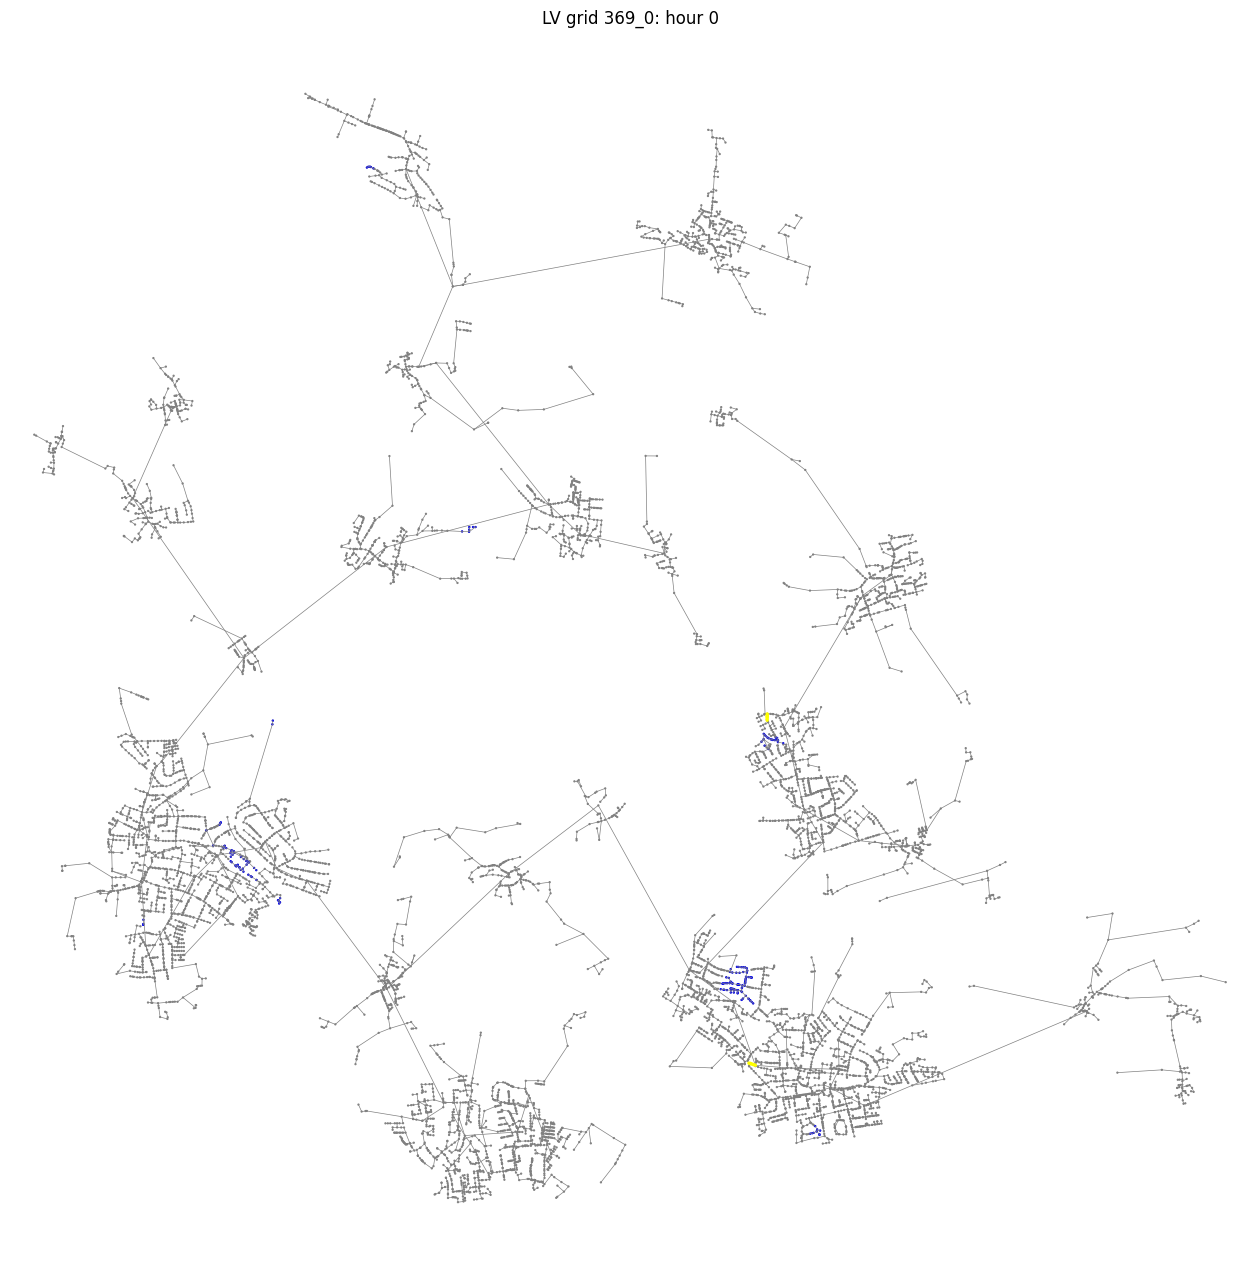

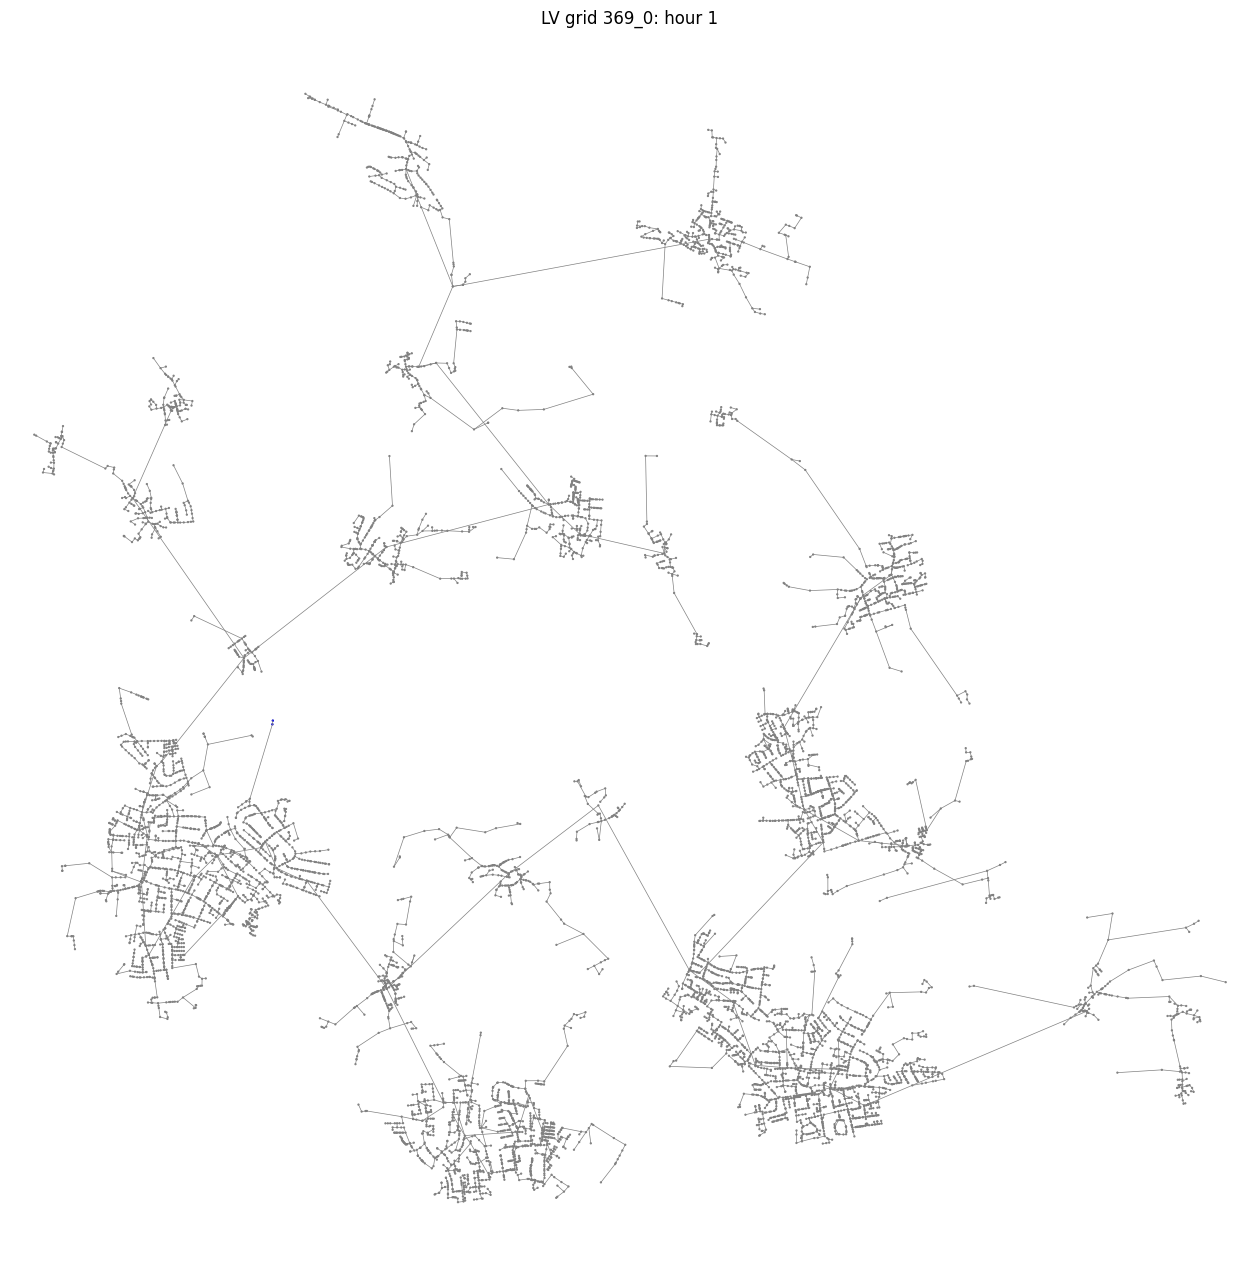

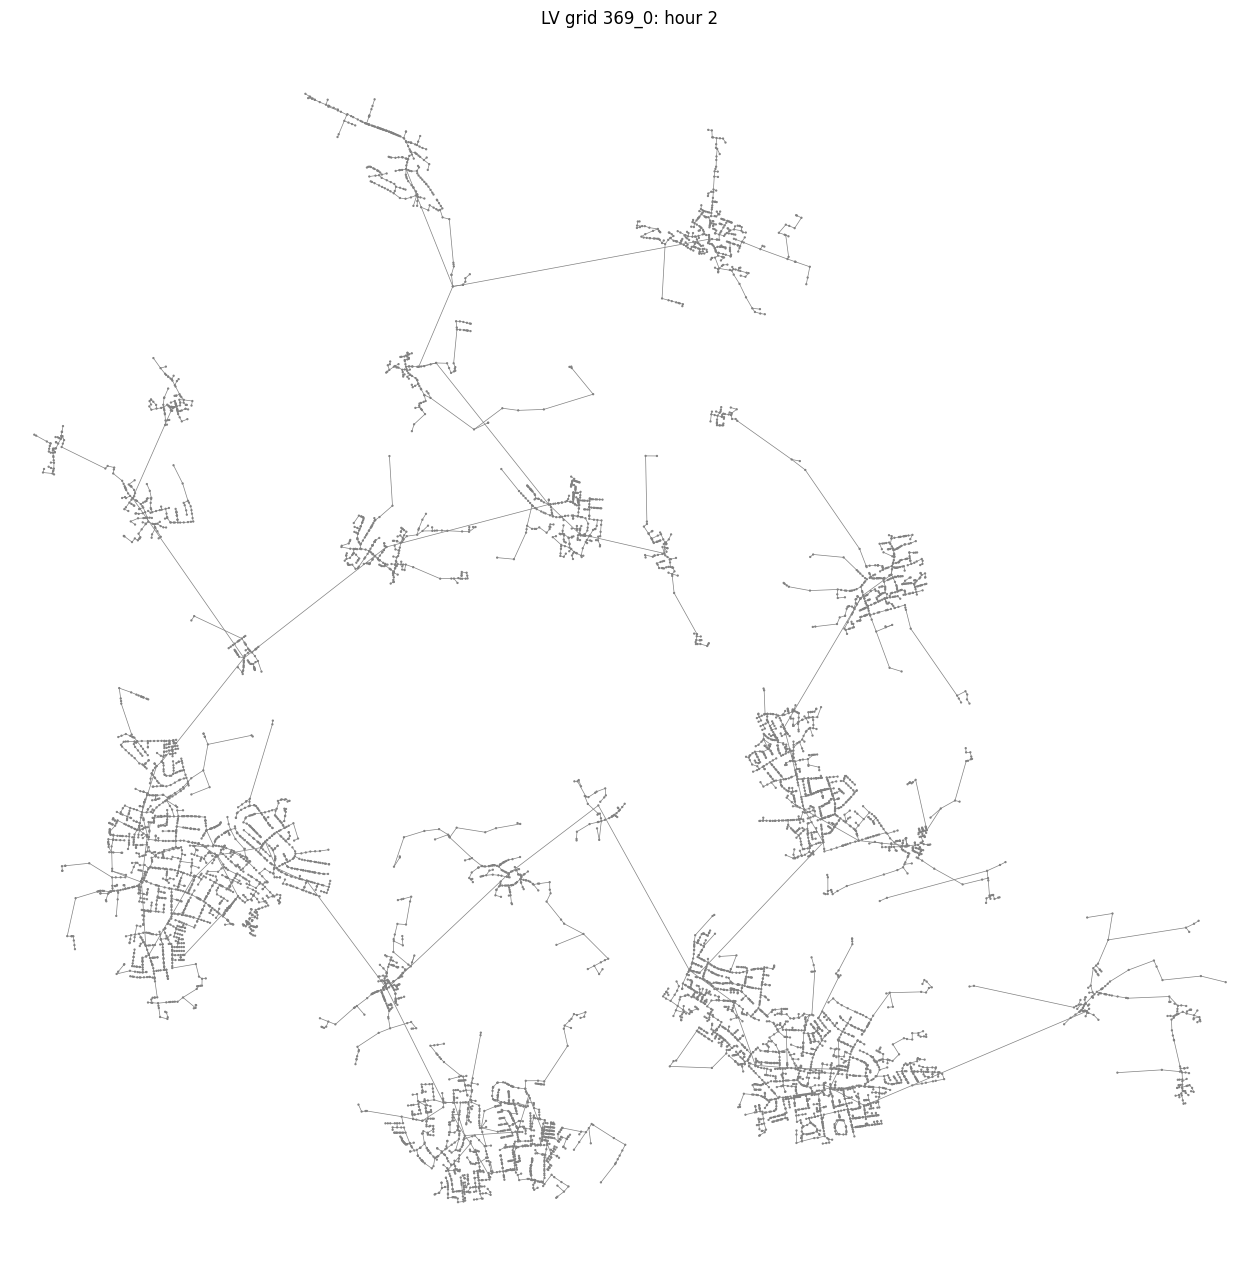

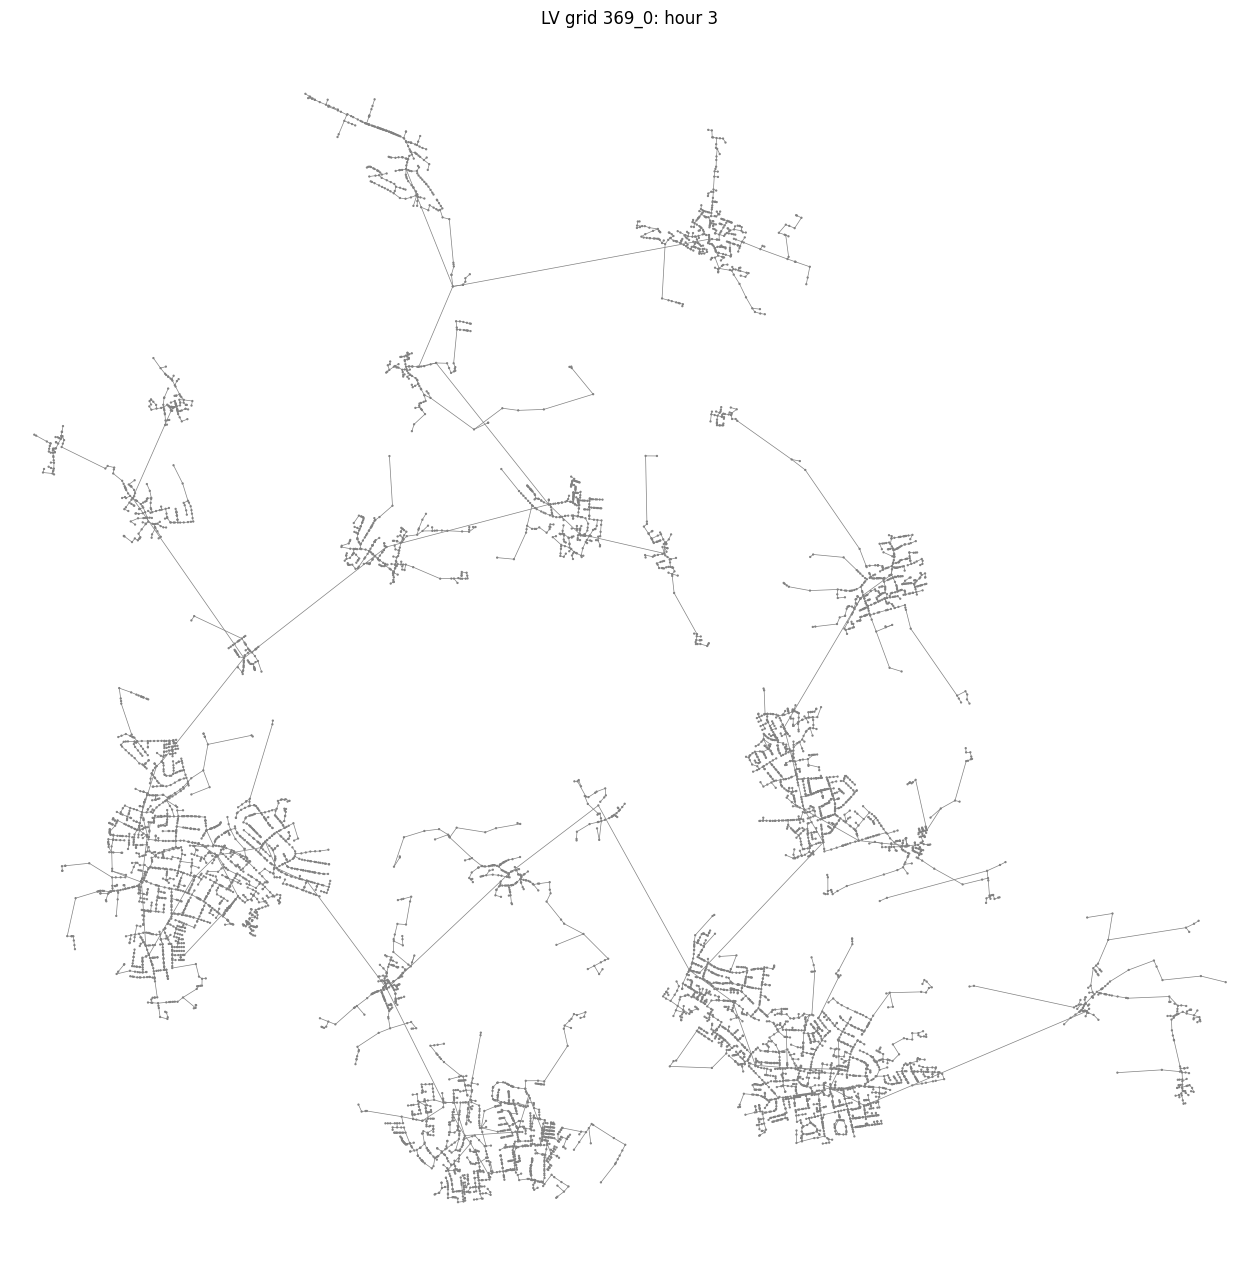

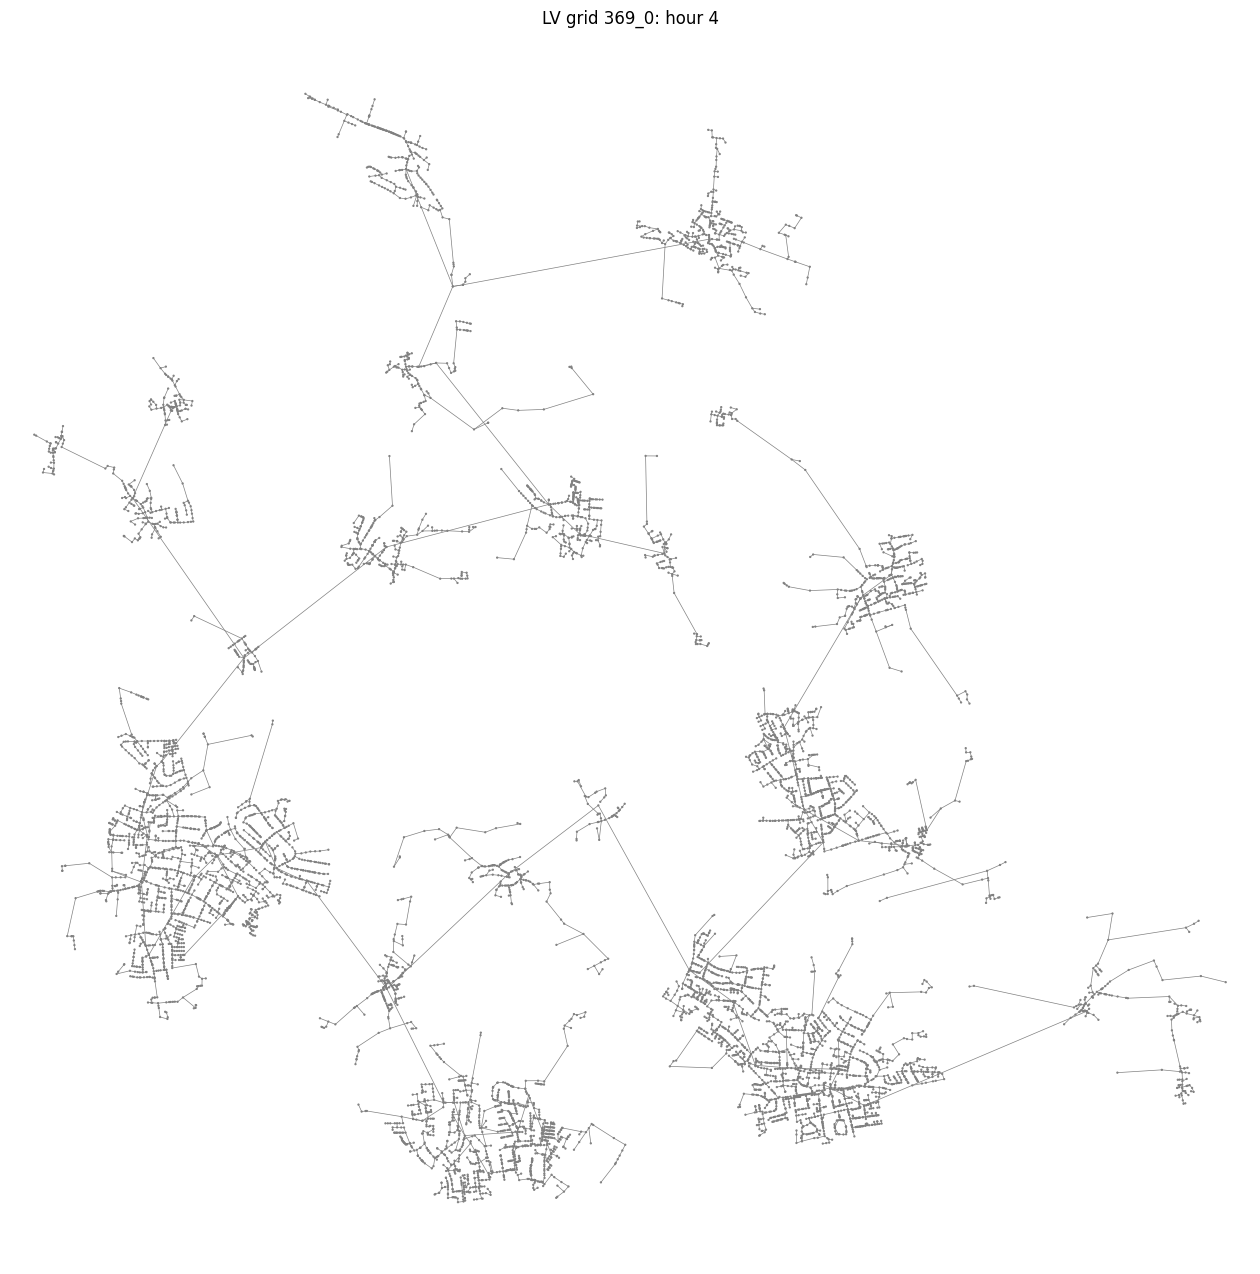

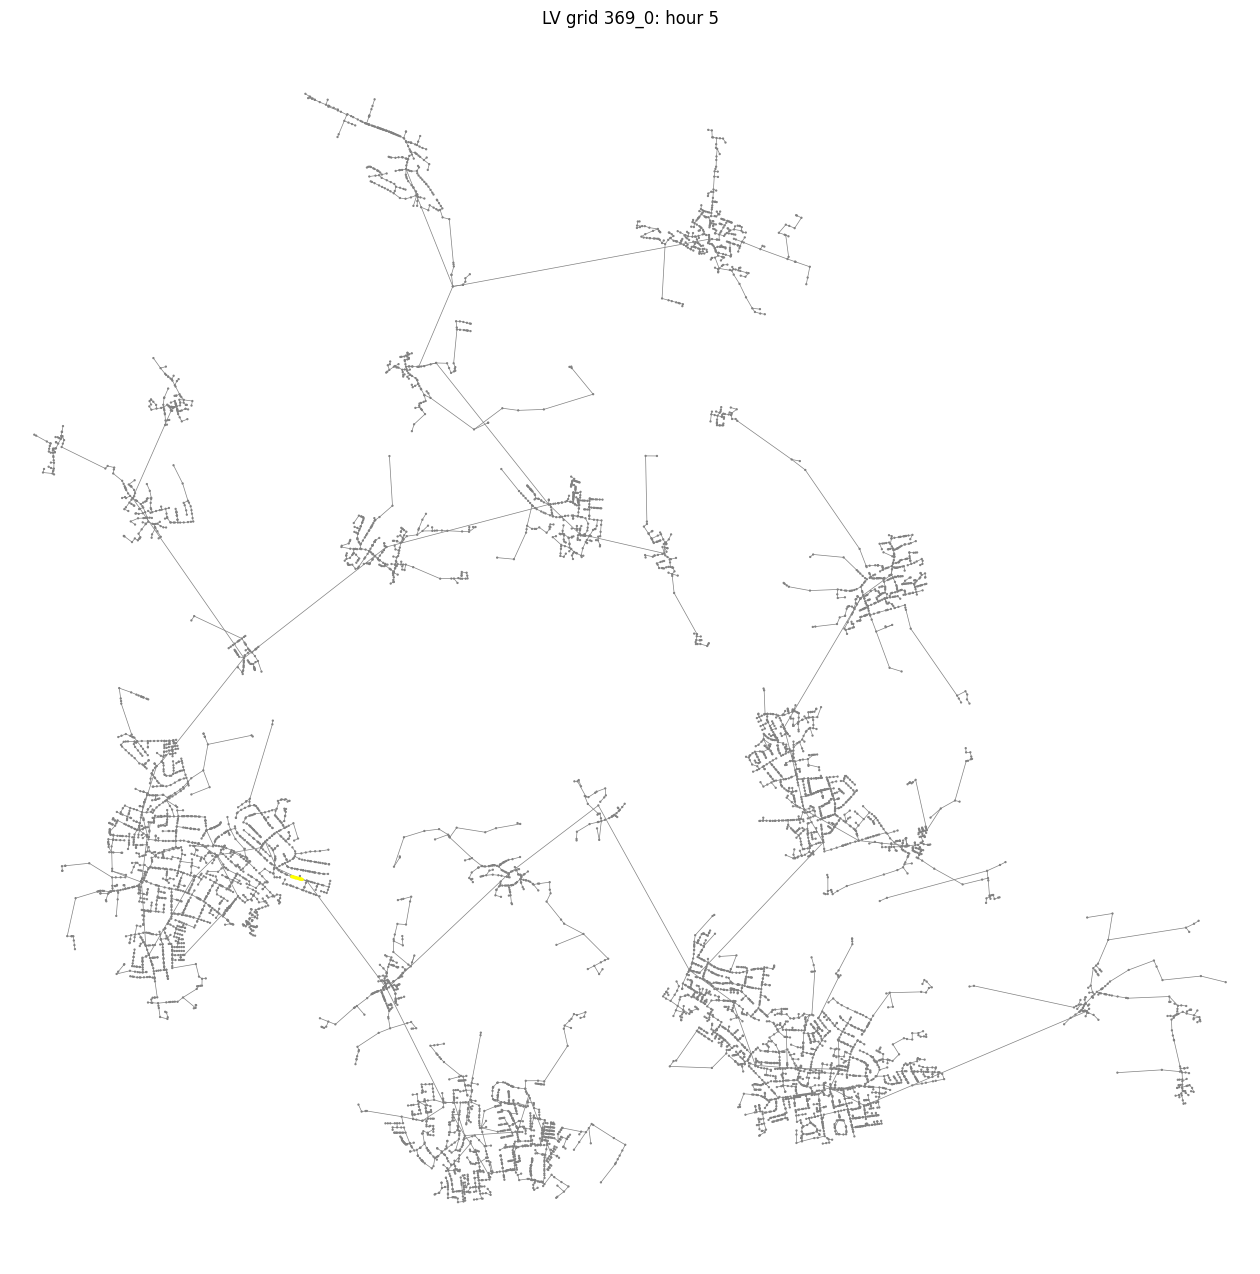

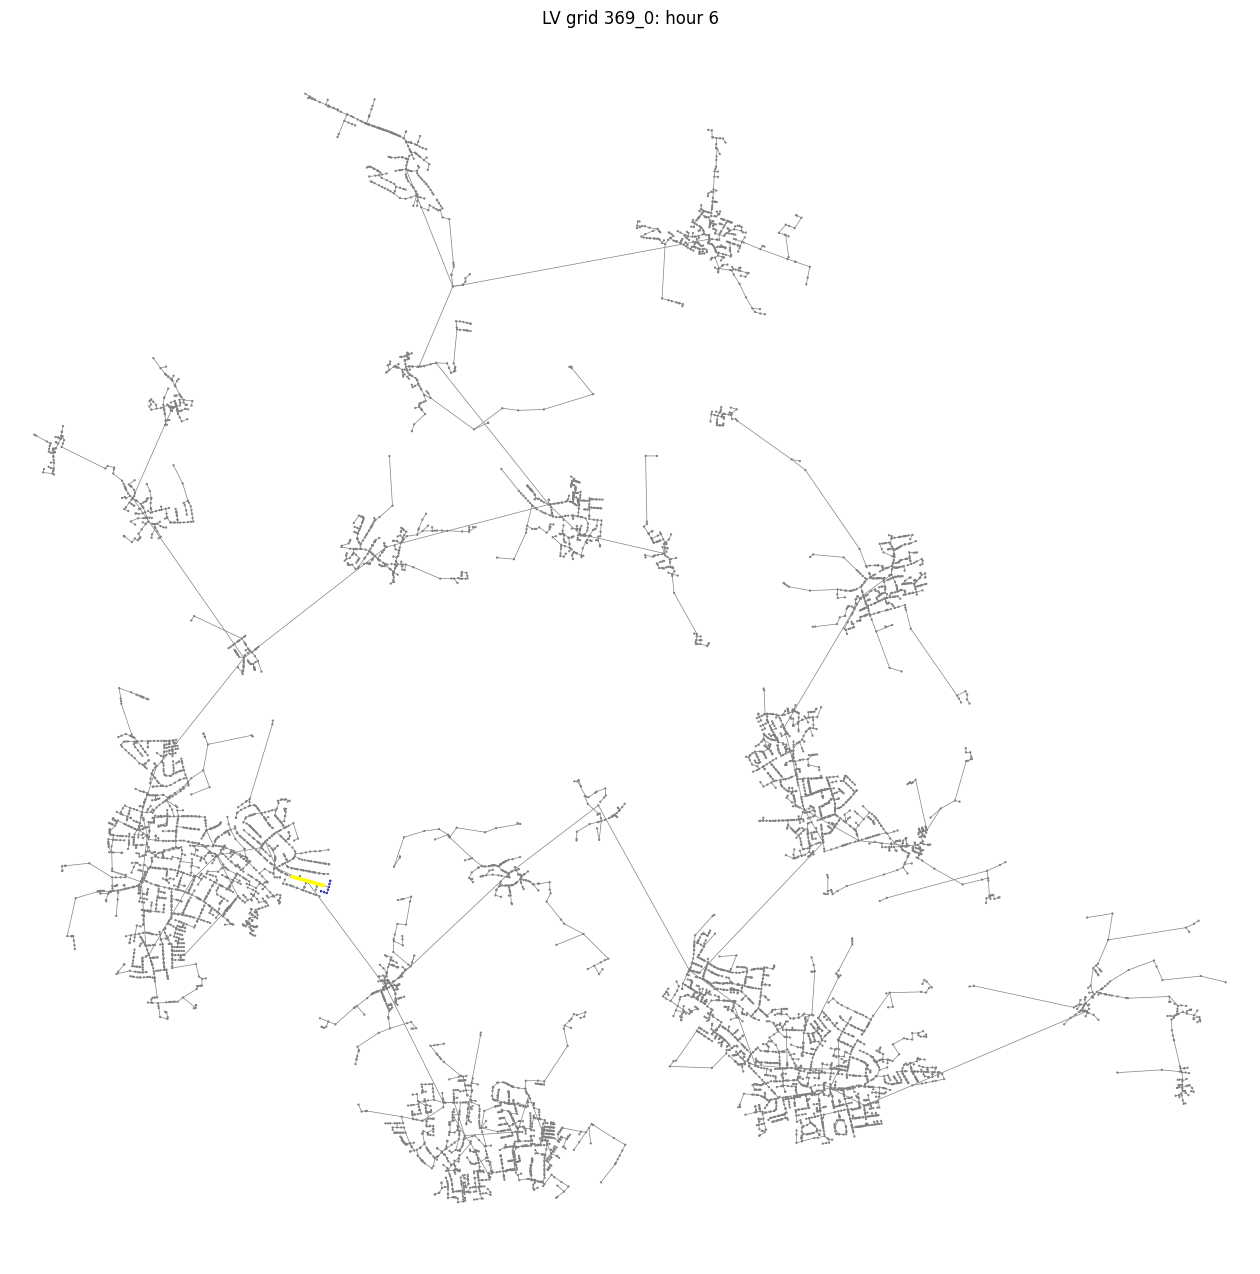

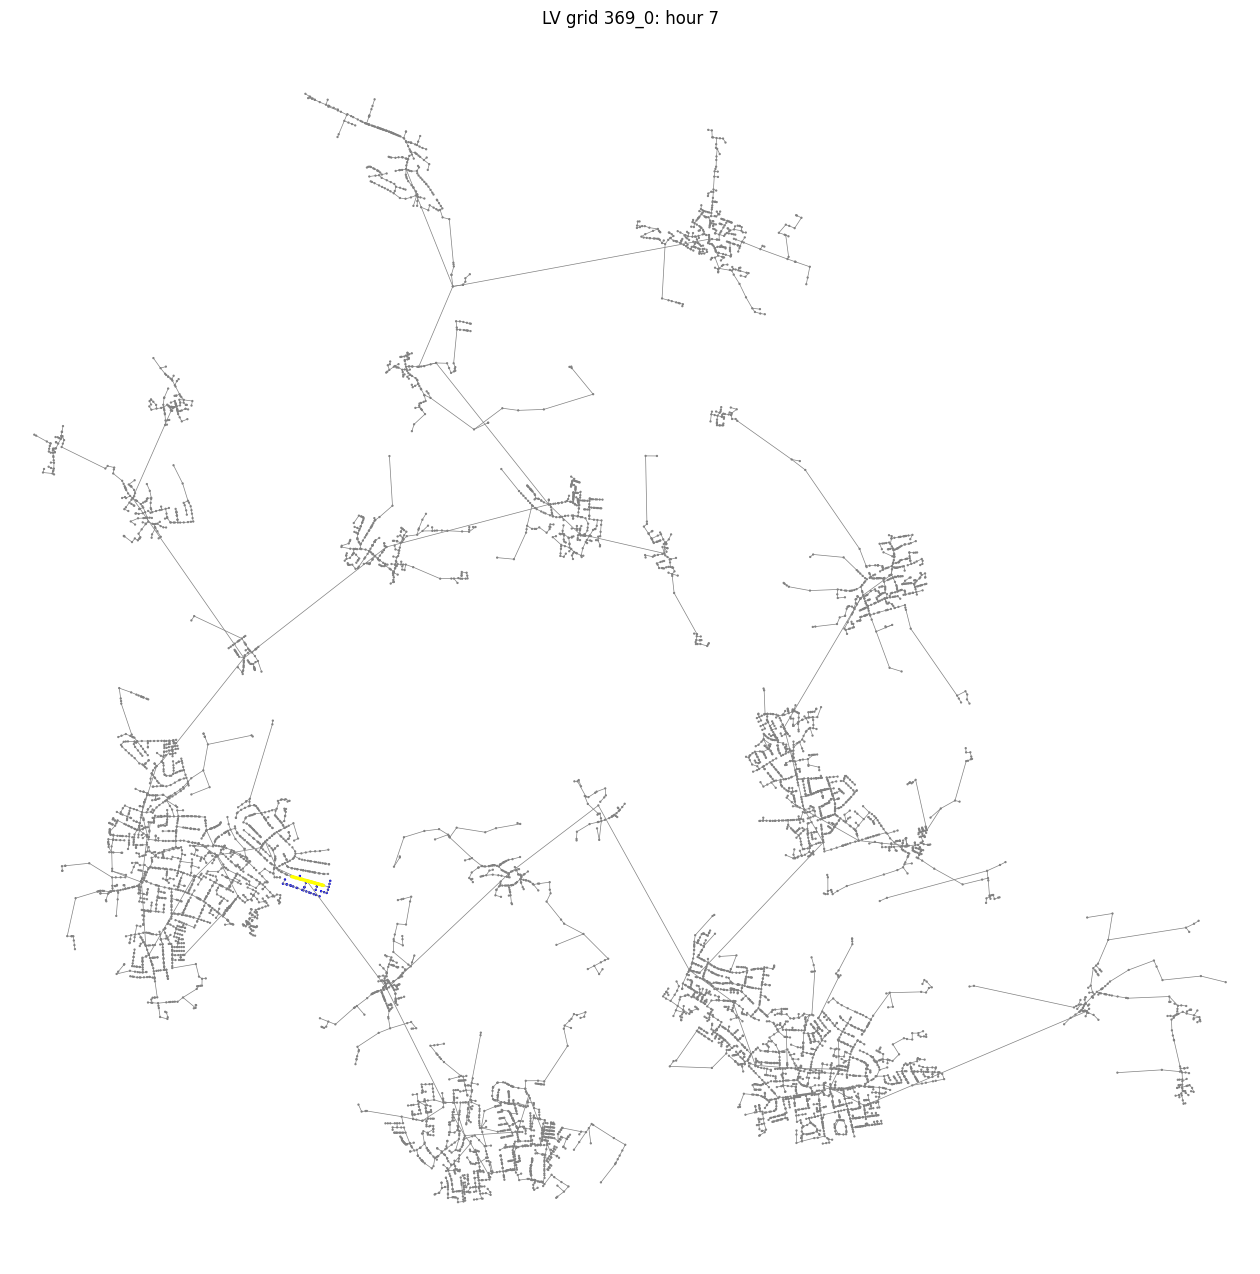

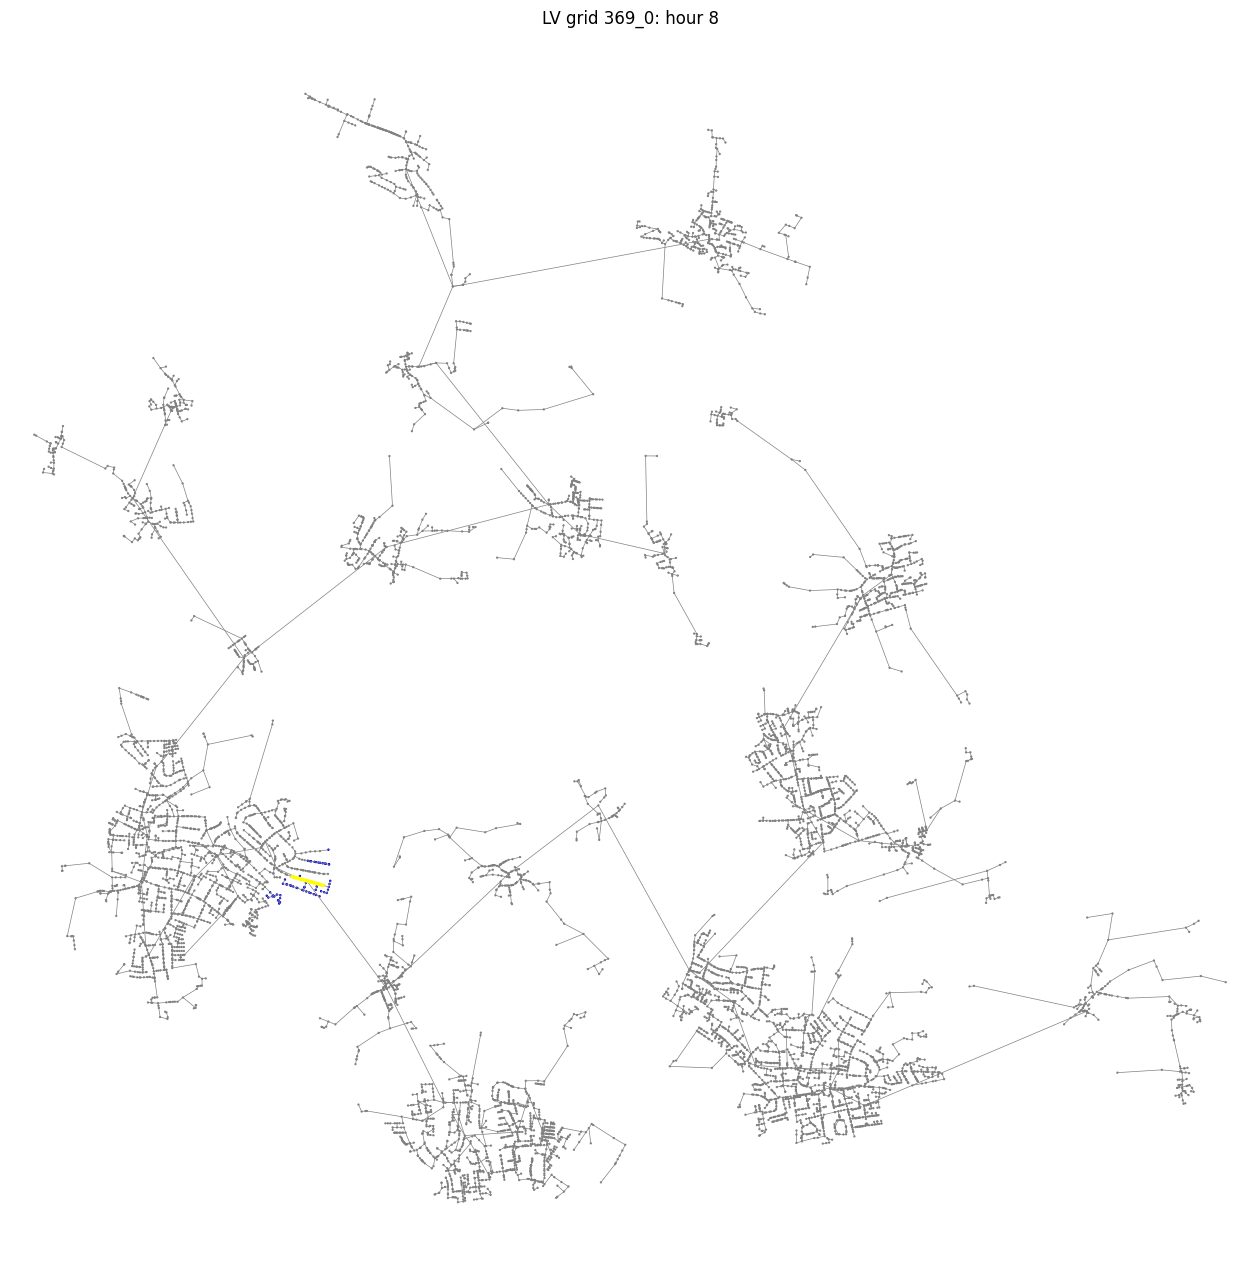

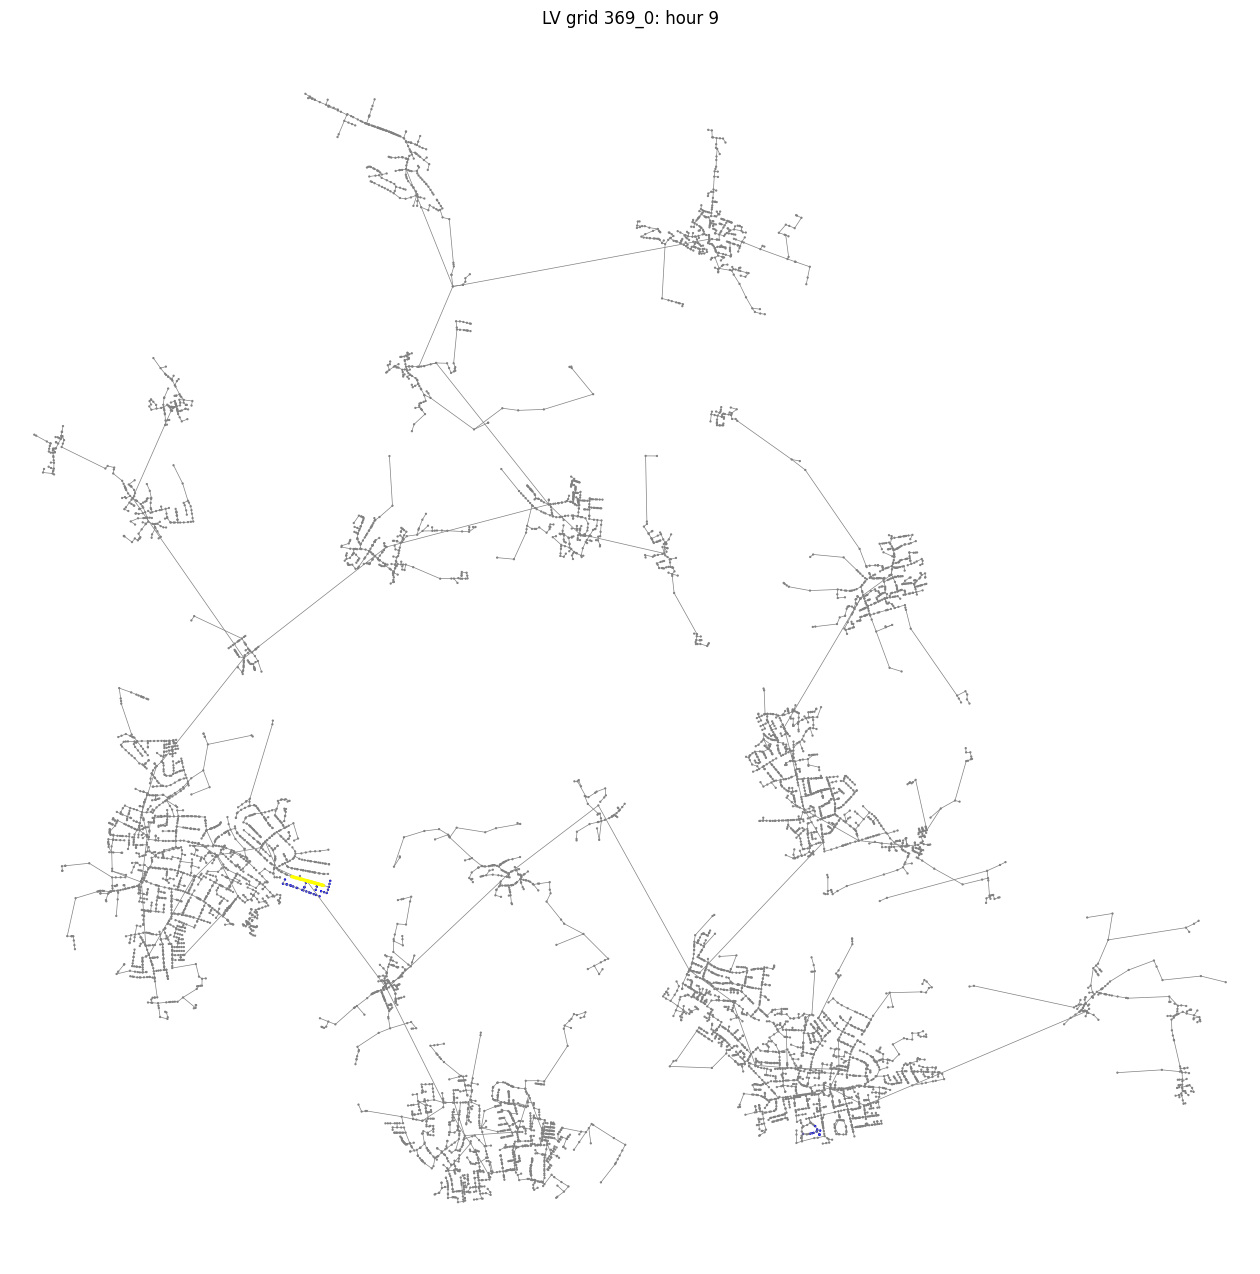

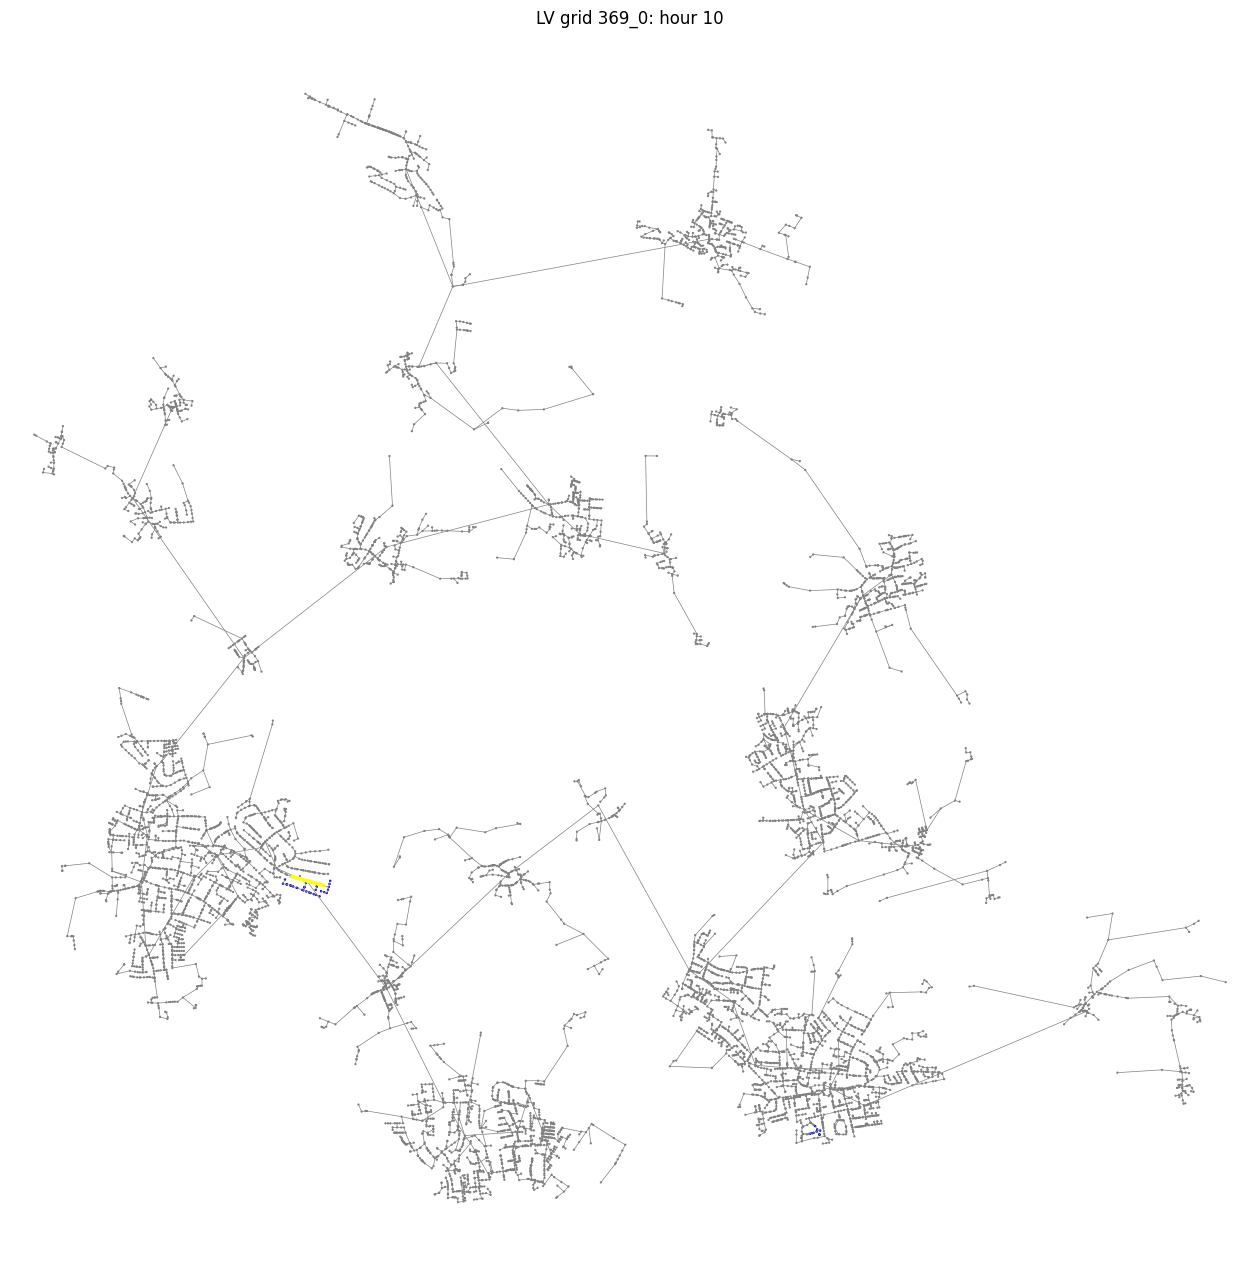

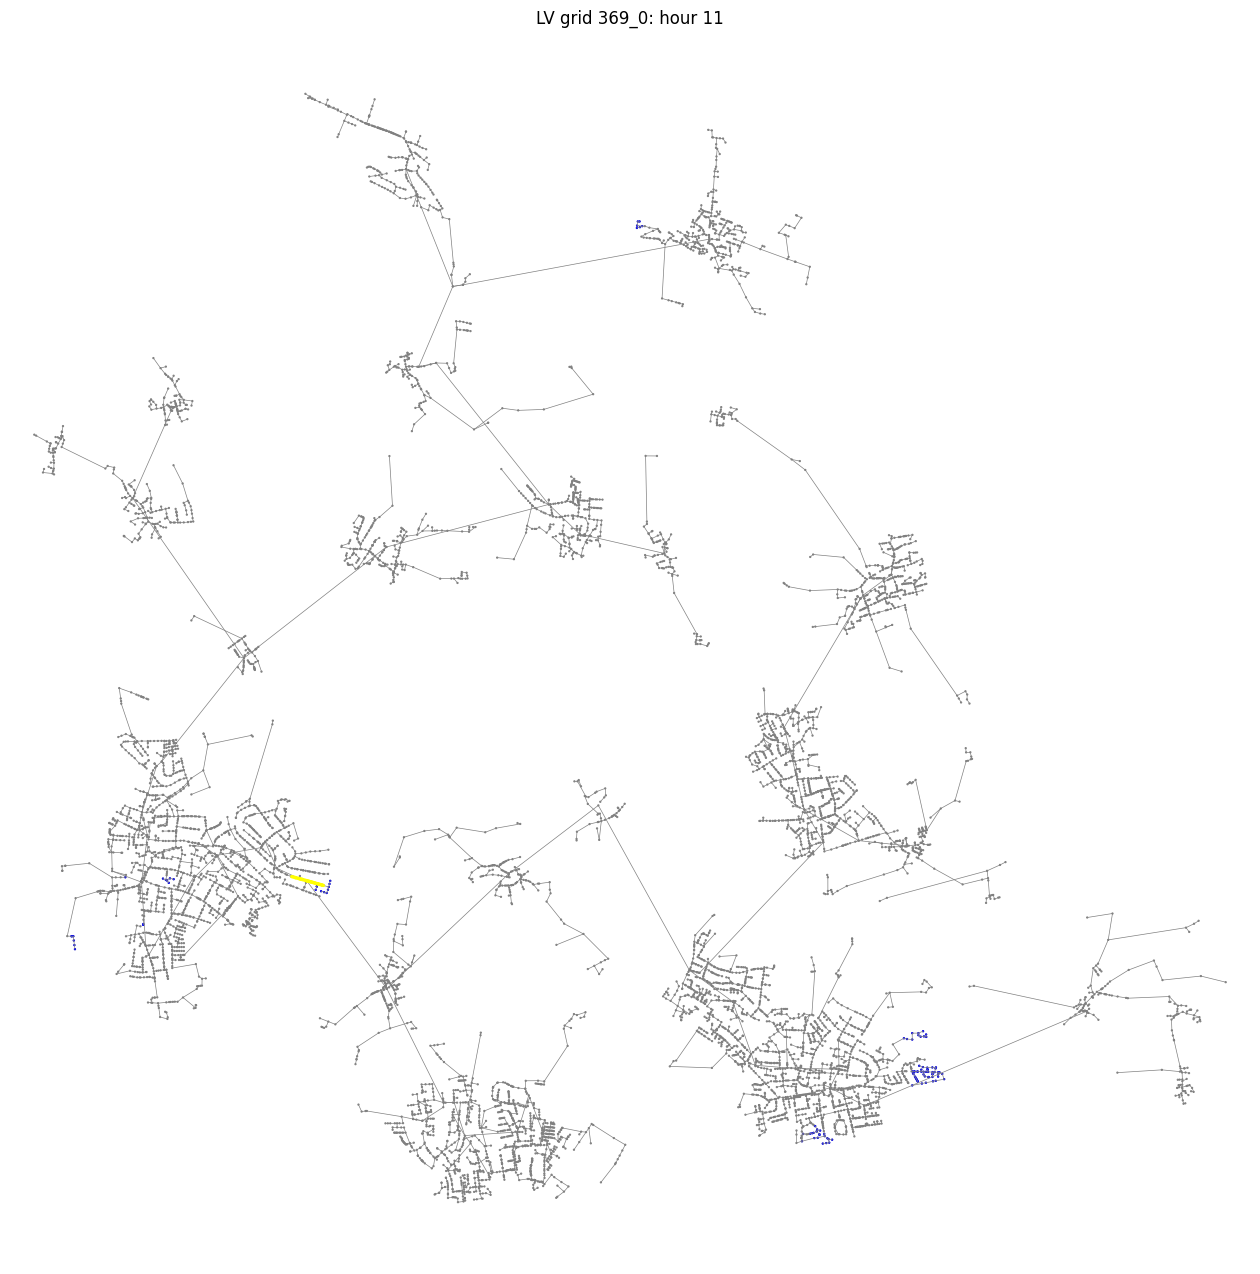

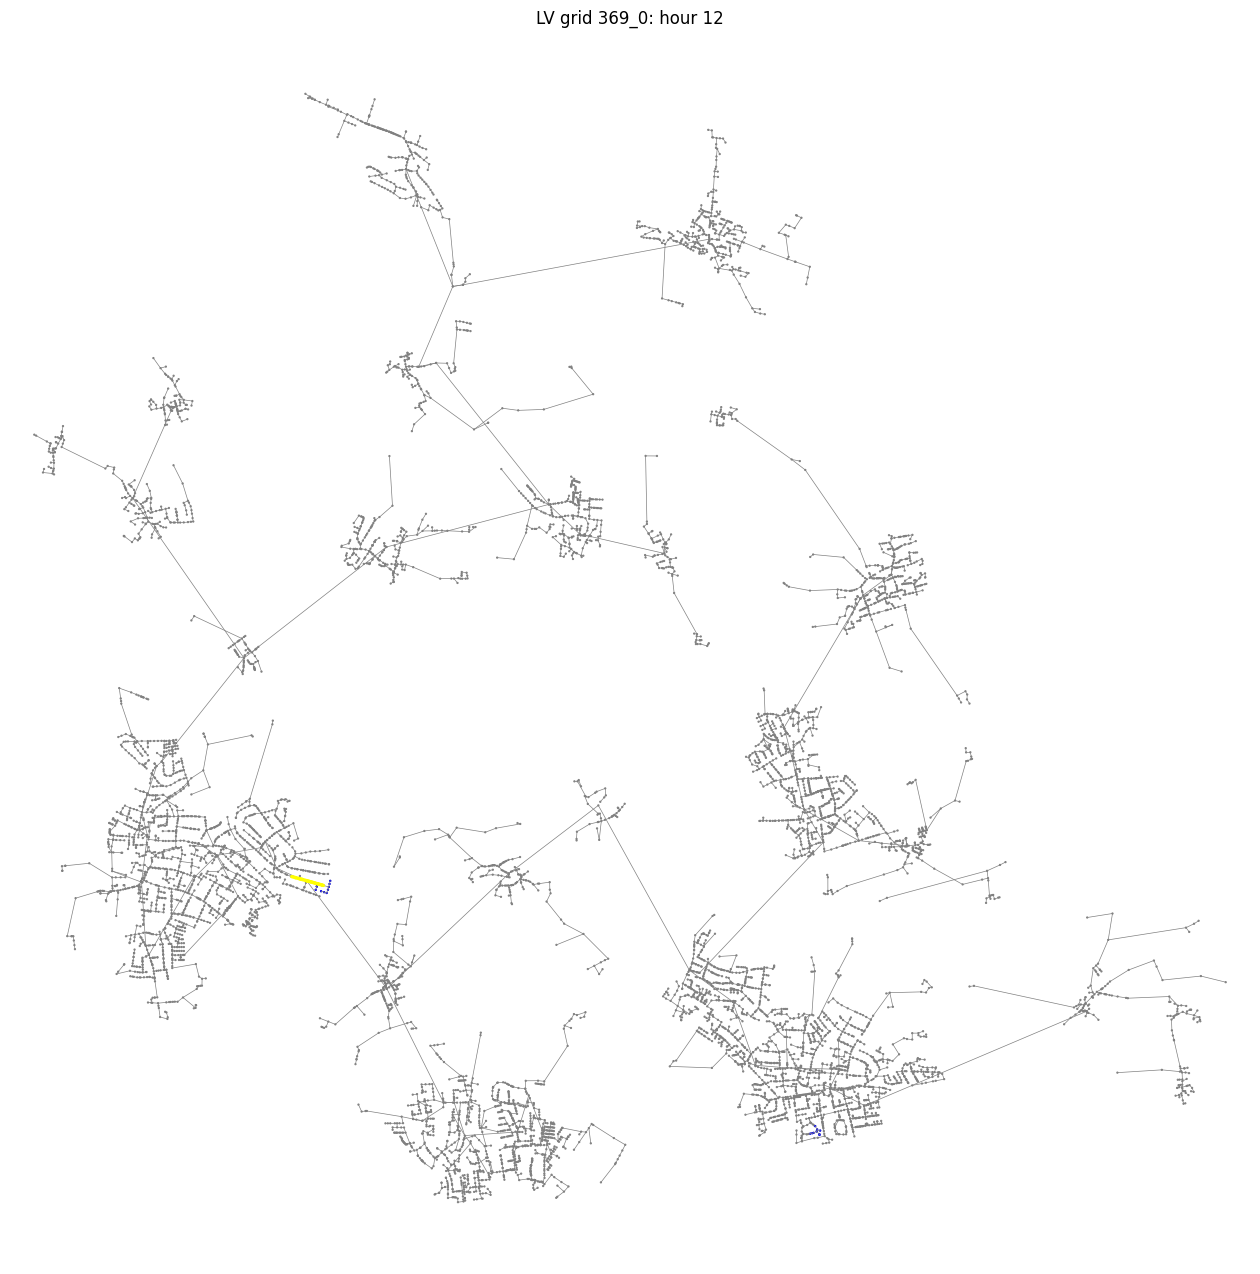

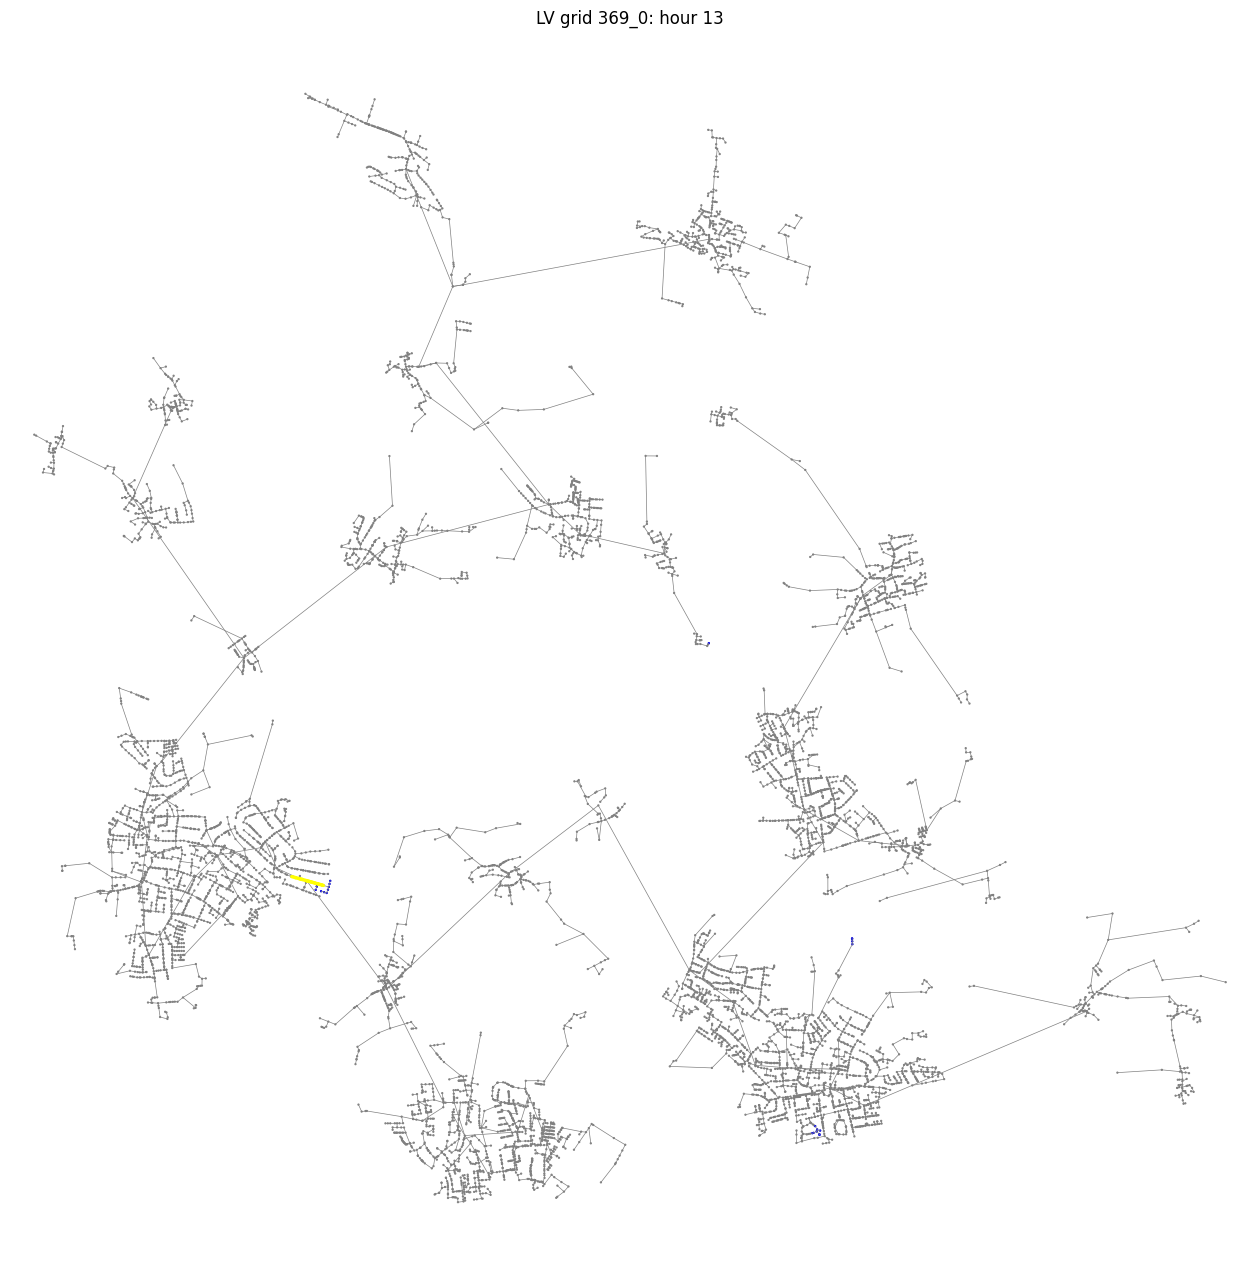

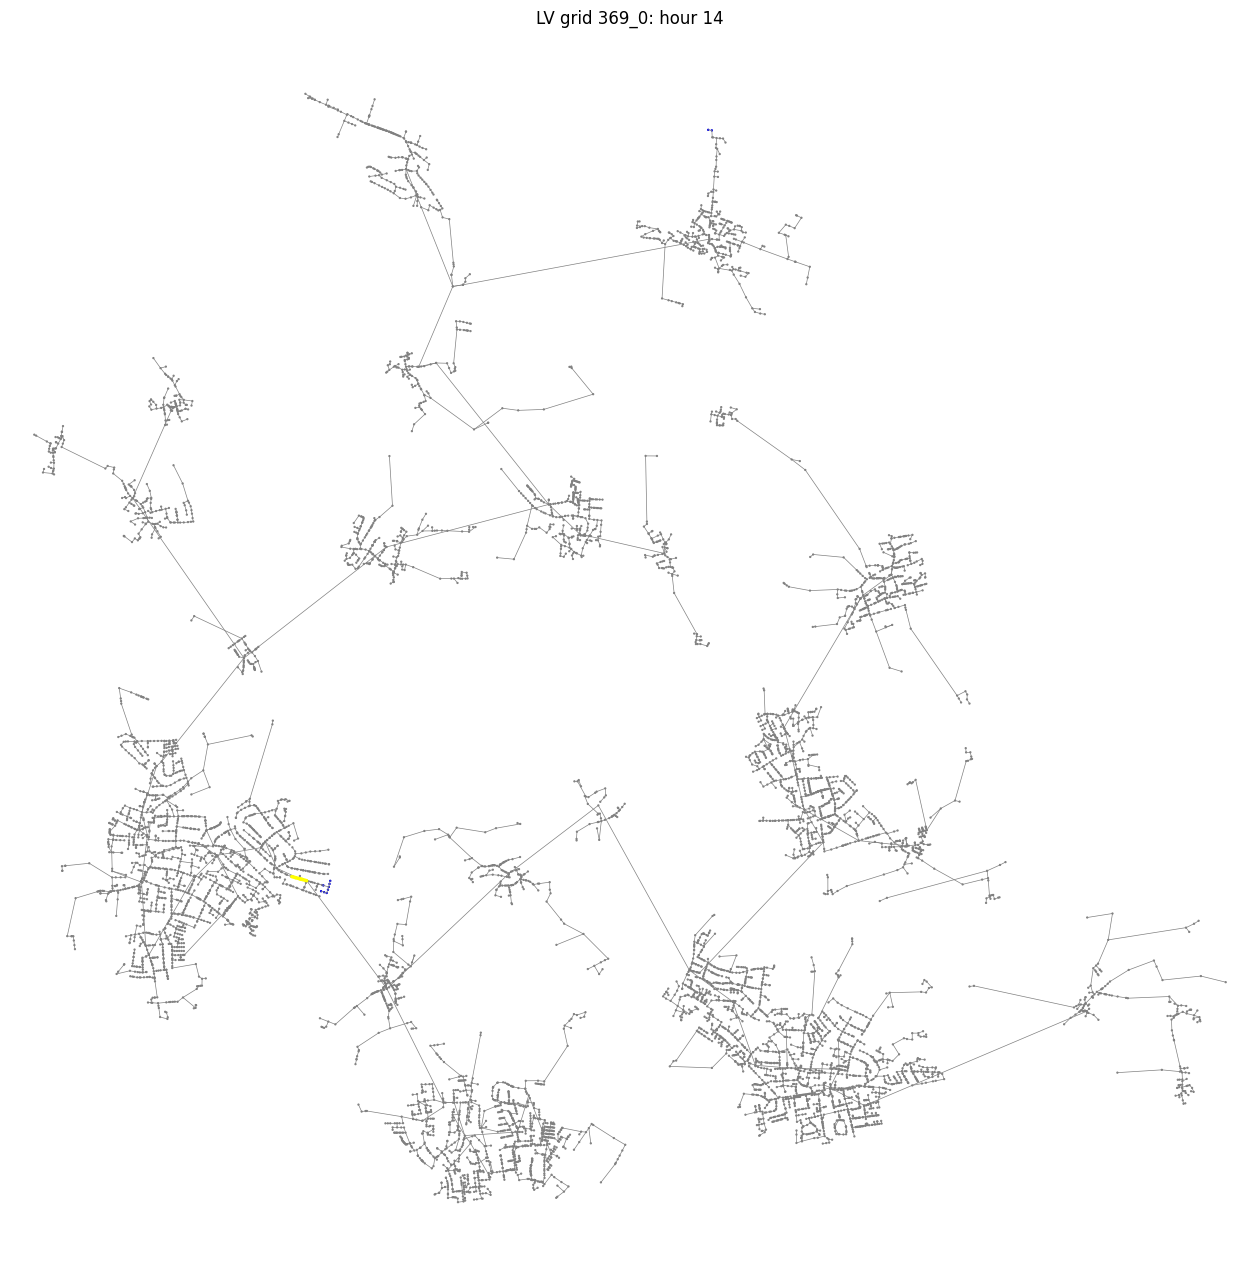

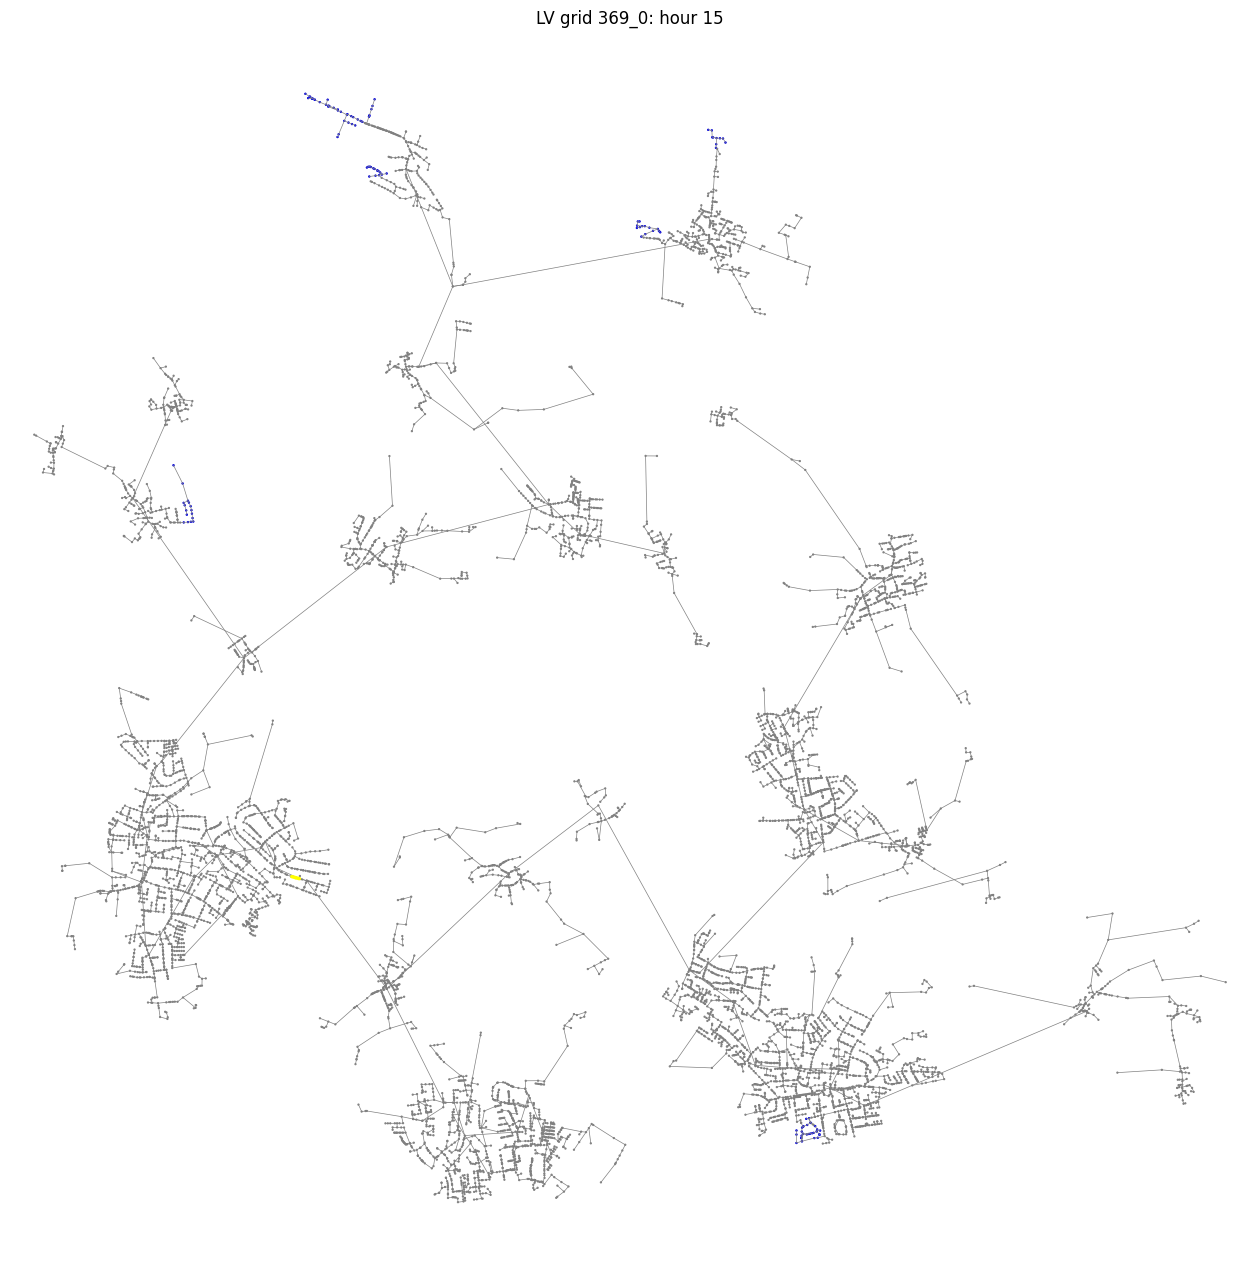

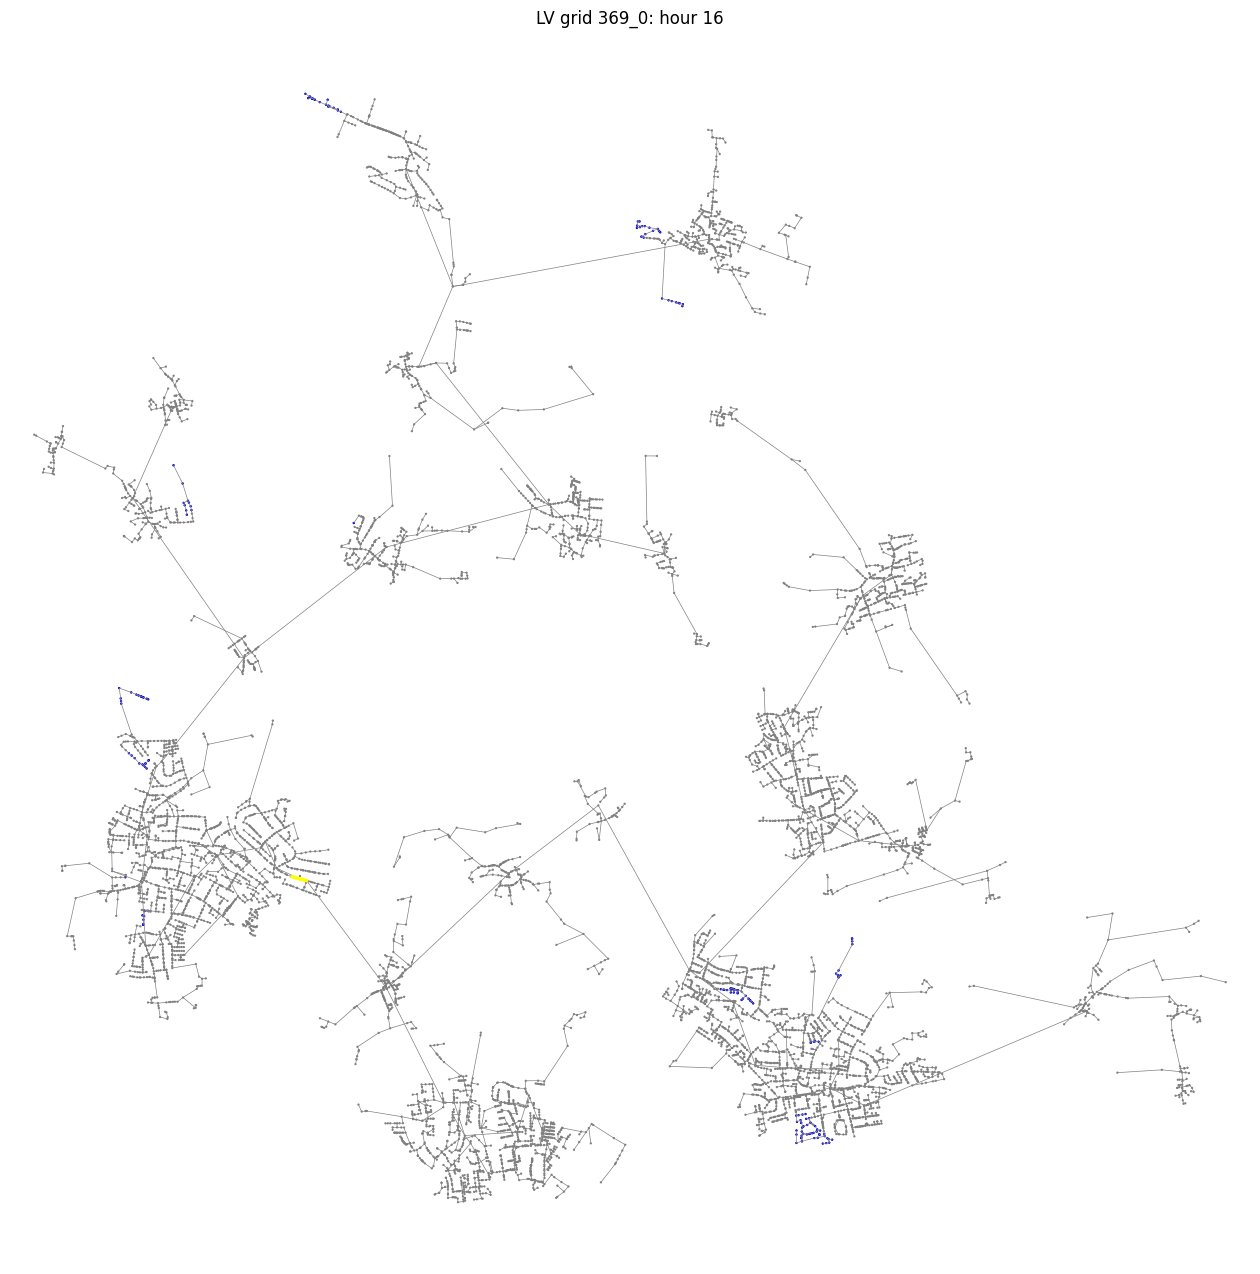

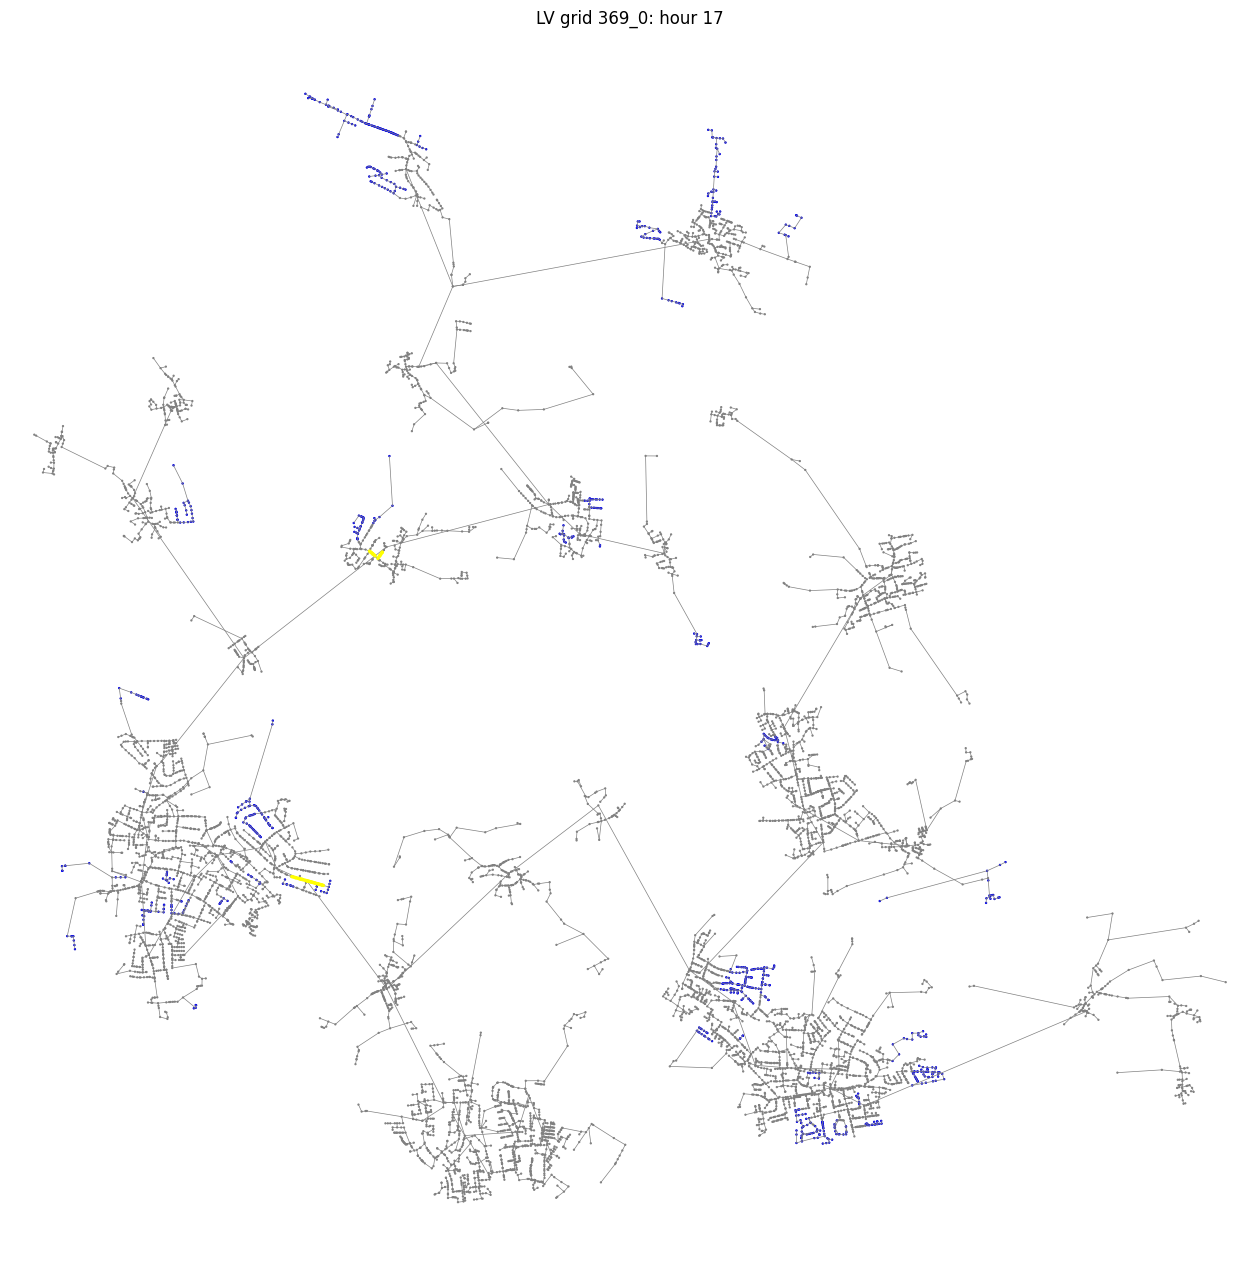

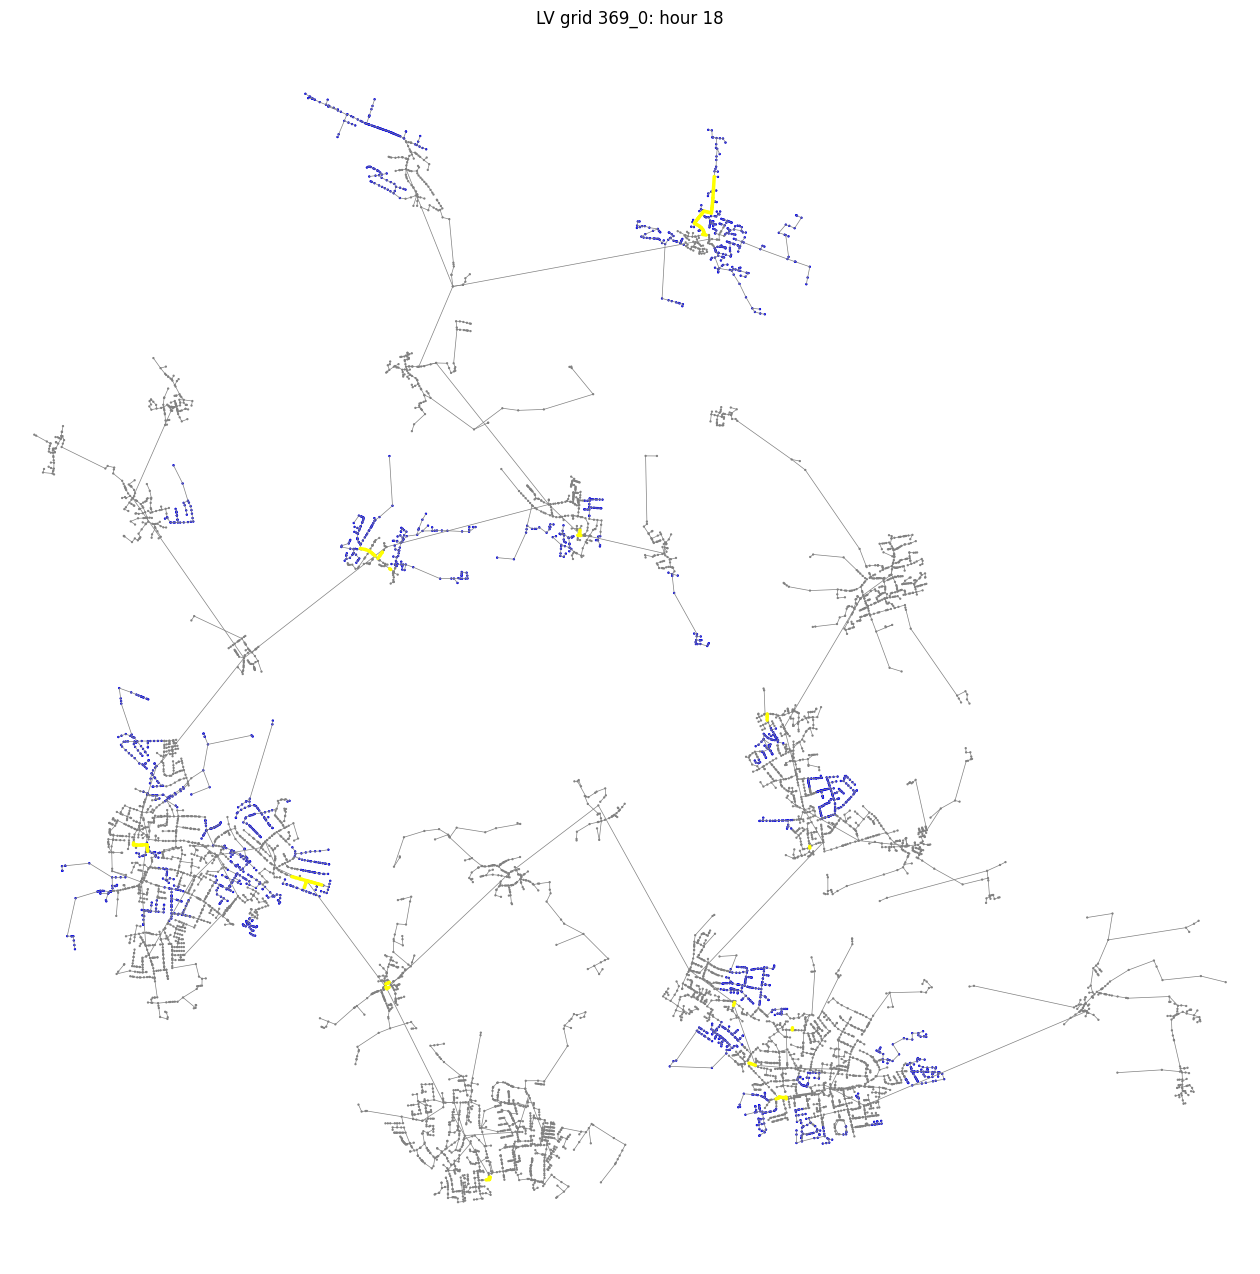

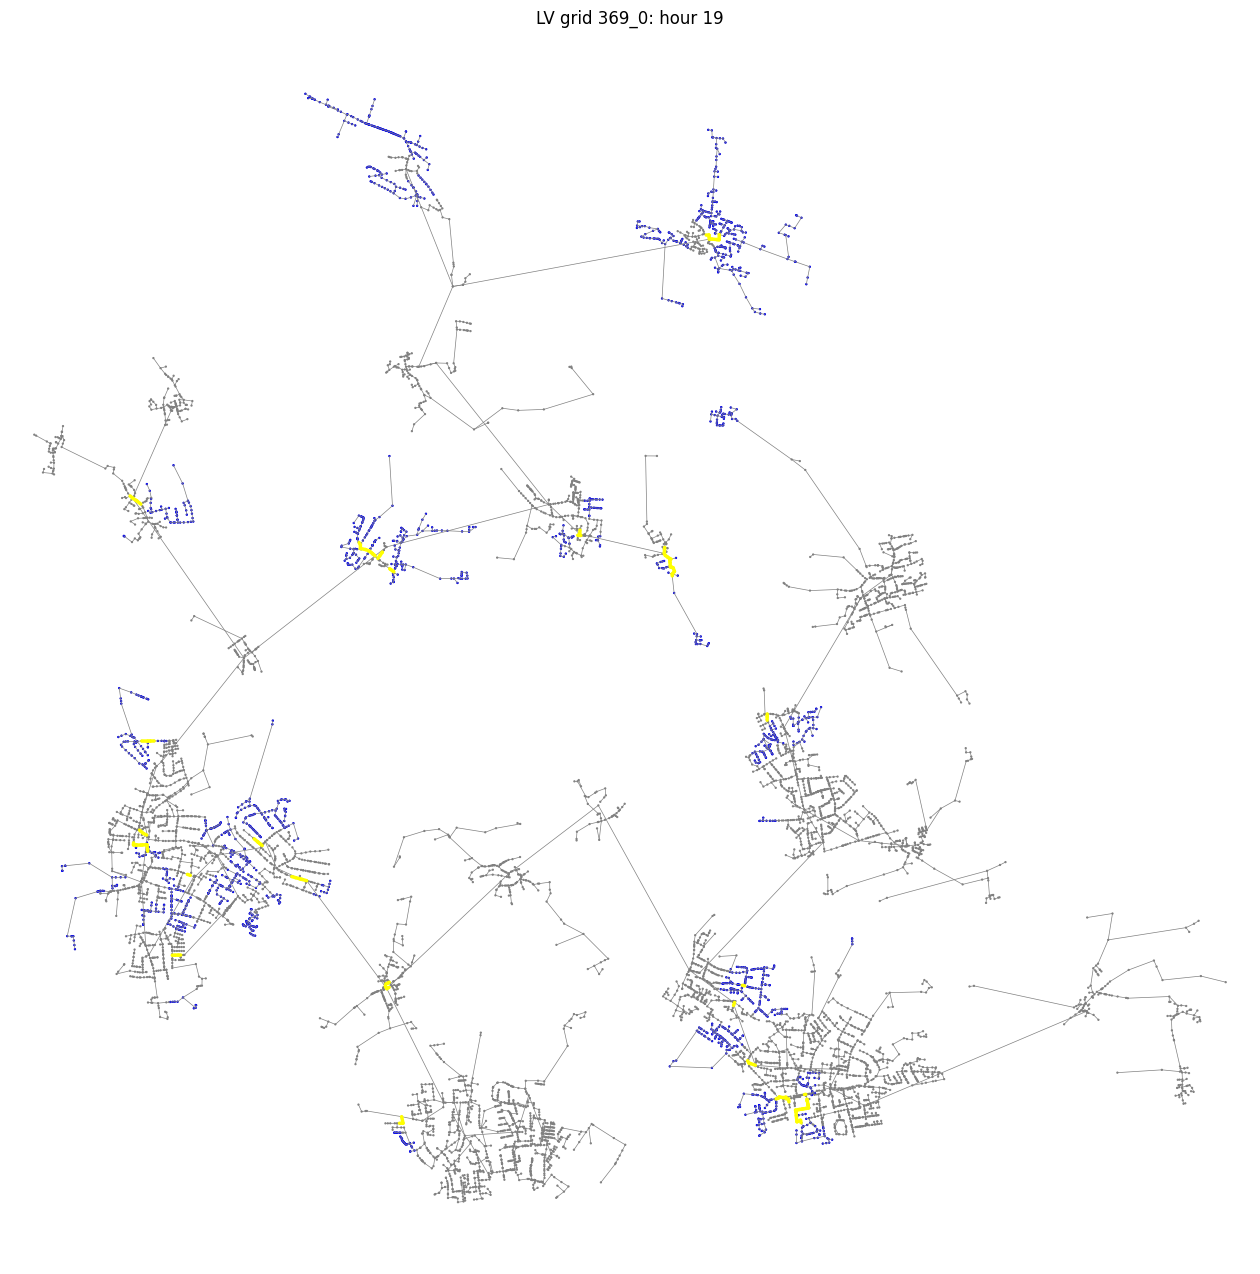

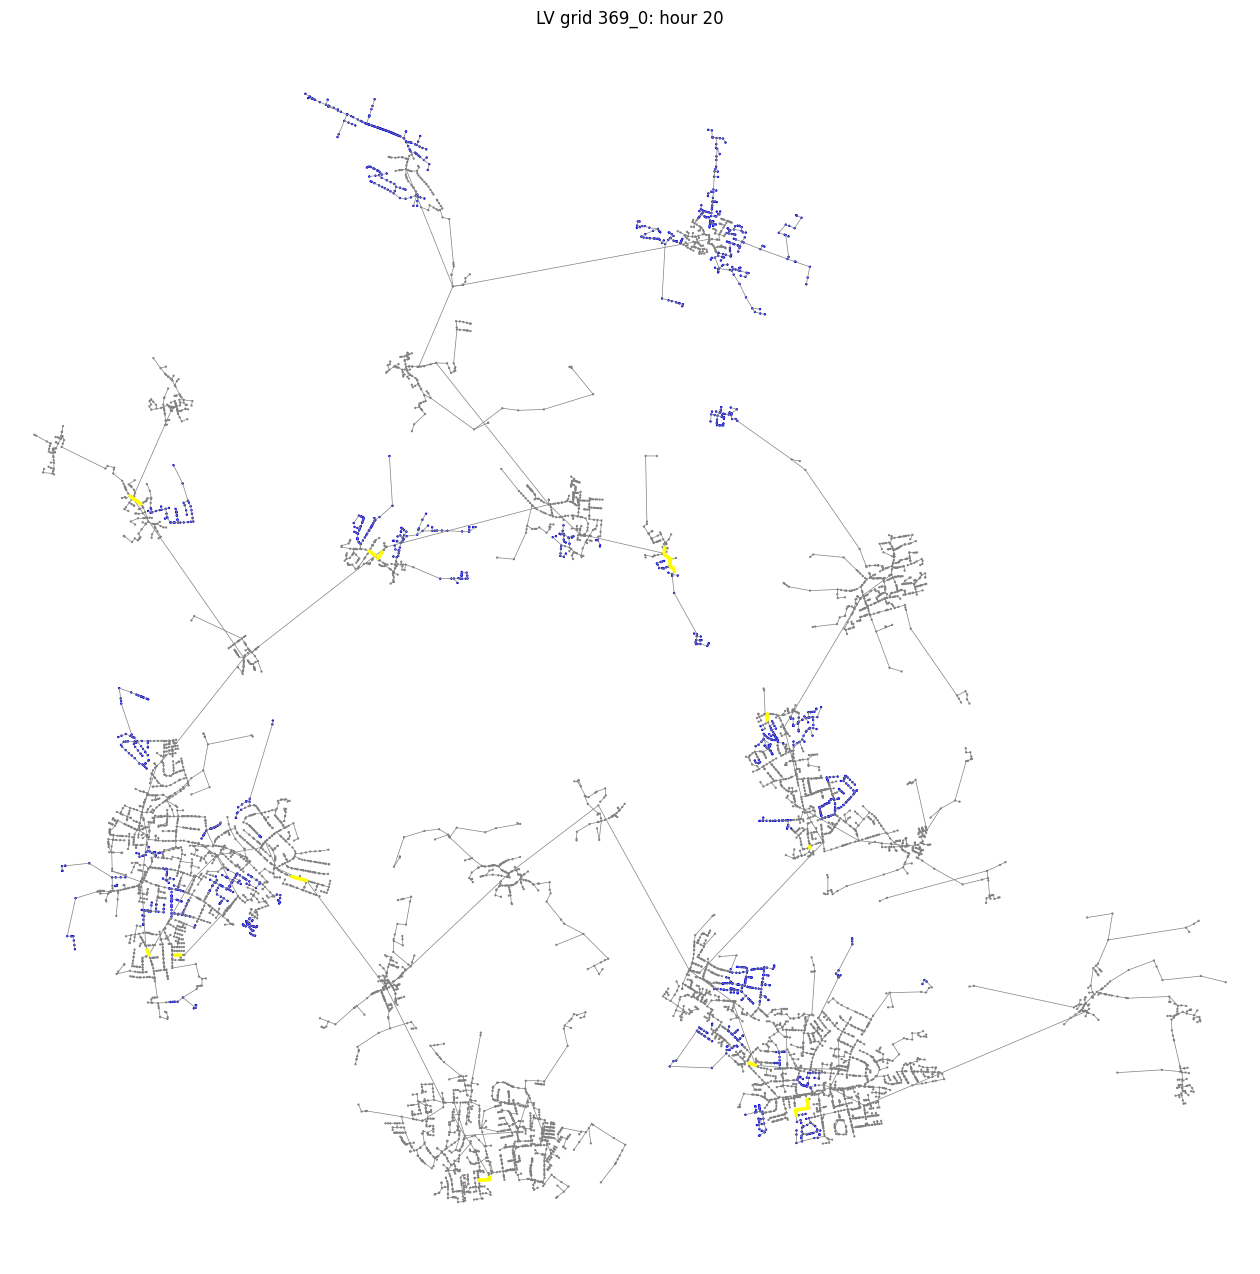

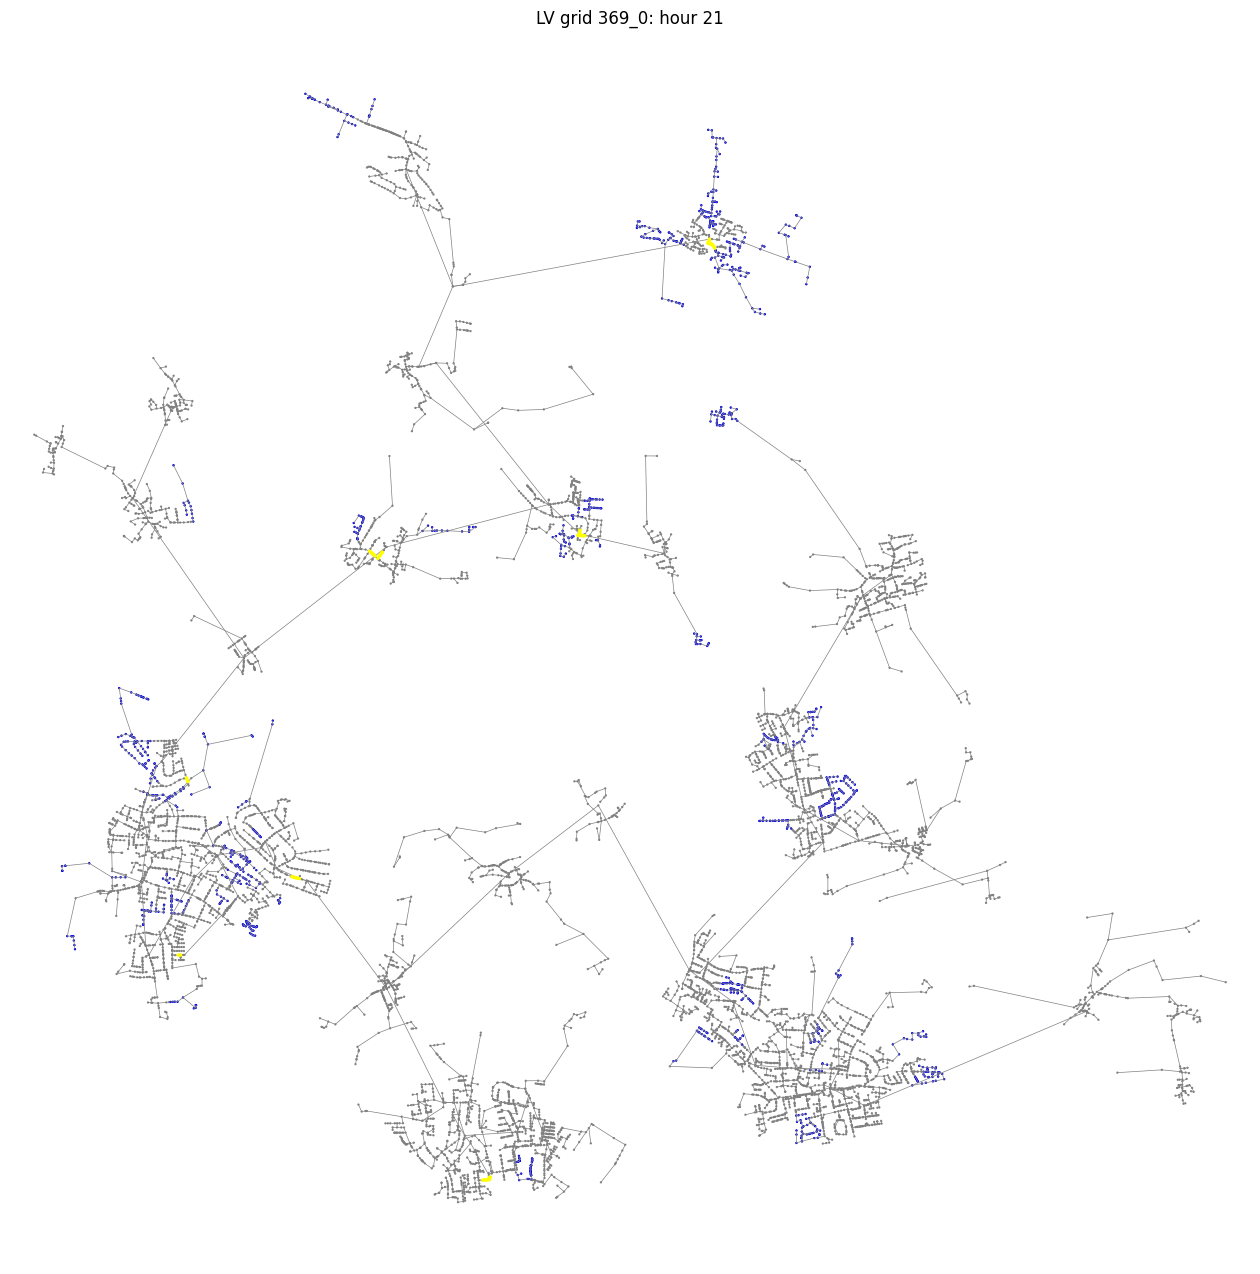

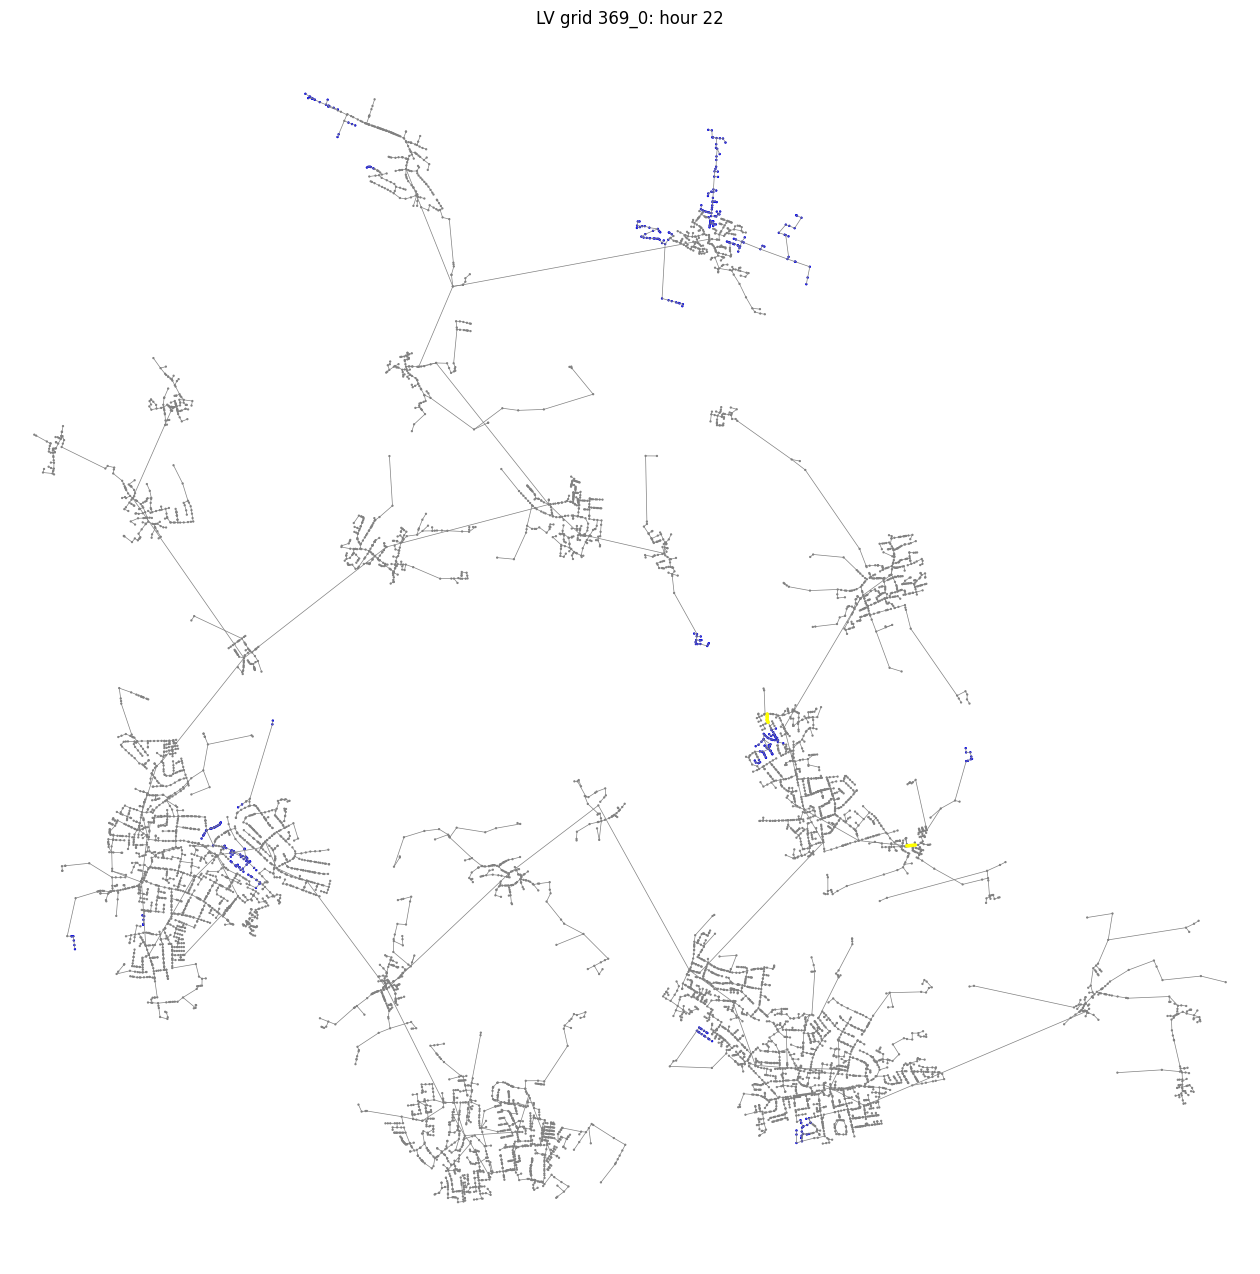

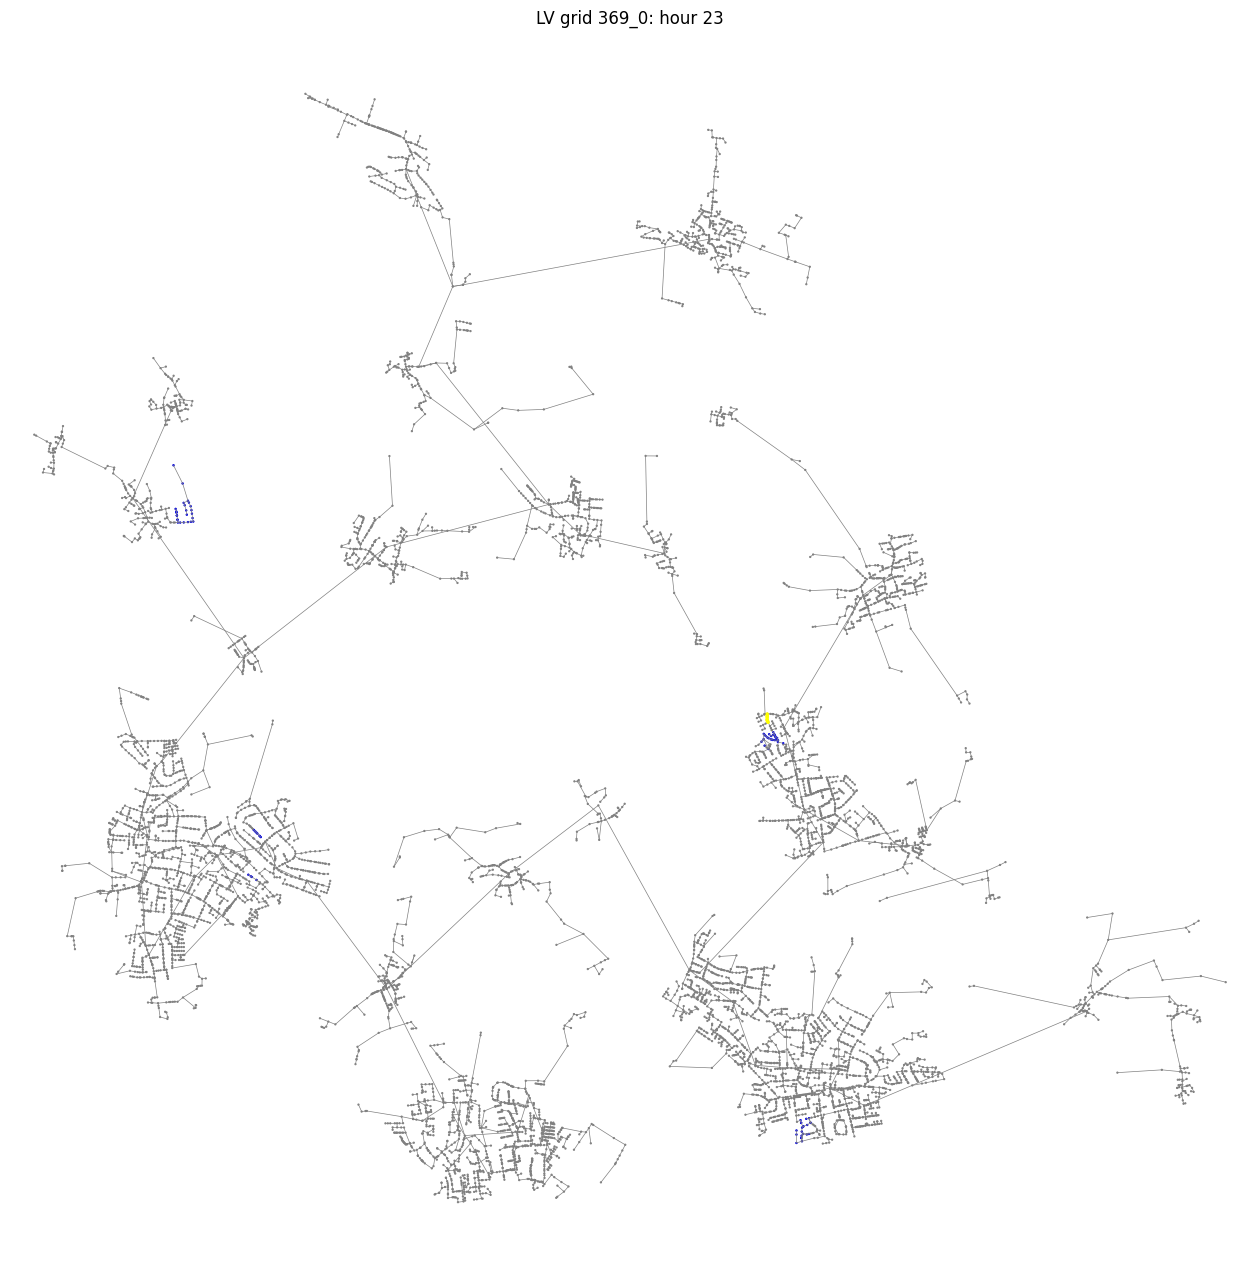

In [56]:
# Define the list of lines to highlight
for t in range(monitor_hr):
    highlight_lines =  [int(line_idx) for line_idx in line_loading.index[line_loading[t]>100]] #[int(line_idx) for line_idx in line_loading.index[line_loading.gt(100).any(axis=1)]]
    highlight_nodes_overvoltage = [int(node_idx) for node_idx in node_vm.index[node_vm[t]>1.1]] #[int(node_idx) for node_idx in node_vm.index[(node_vm > 1.1).any(axis=1)]]
    highlight_nodes_undervoltage = [int(node_idx) for node_idx in node_vm.index[node_vm[t]<0.9]] #[int(node_idx) for node_idx in node_vm.index[(node_vm < 0.9).any(axis=1)]]

    fig, ax = plt.subplots(figsize=(16, 16))
    # Plotting the network
    lc = pp.plotting.create_line_collection(network, lines=highlight_lines, color='yellow', linewidth=2.5, use_bus_geodata=True,label='Overloaded_lines')
    bc_over = pp.plotting.create_bus_collection(network, buses=highlight_nodes_overvoltage,color='red',size=3, patch_type='circle')
    bc_under = pp.plotting.create_bus_collection(network, buses=highlight_nodes_undervoltage,color='blue',size=3, patch_type='circle')

    # Add the default line collection for non-highlighted lines
    default_lc = pp.plotting.create_line_collection(network, lines=None, use_bus_geodata=True, color="grey", linewidth=0.5,cbar_title='Line Loading [%]',label='Line normal operation')
    default_bc = pp.plotting.create_bus_collection(network, buses=None, color="grey", size=3, patch_type='circle',cbar_title='Bus Voltage [pu]',label='Nodes normal operation')

    red_node = mlines.Line2D([], [], color='red', marker='o', markersize=3, label='Overvoltage Nodes', linestyle='None')
    blue_node = mlines.Line2D([], [], color='blue', marker='o', markersize=3, label='Undervoltage Nodes', linestyle='None')
    

    pp.plotting.draw_collections([default_lc,lc,default_bc,bc_over,bc_under], figsize=(16, 16),ax=ax)
    # ax.legend(handles=[lc,red_node,blue_node])

    # # Plotting with trafos
    # tc = pp.plotting.create_trafo_collection(network, trafos=None, color="magenta", size=1.0,label='trafo')
    # tc_point = mlines.Line2D([],[],color="magenta",marker='o',markersize=3, label='Trafo',linestyle='None')
    # pp.plotting.draw_collections([default_lc,lc,default_bc,bc_over,bc_under,tc], figsize=(16, 16),ax=ax)
    # ax.legend(handles=[lc,red_node,blue_node,tc_point])

    if MV_feeder:
        ax.set_title(f"LV grid {grid}: hour {t}")
        plt.savefig(f"/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/mobility/{path}/{experiment}/res_plot/overloaded_hour_{t}.png")

    
    else:
        ax.set_title(f"LV grid {folder}: hour {t}")
        plt.savefig(f"/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/mobility/{path}/{folder}/{experiment}/res_plot/overloaded_hour_{t}.png")



In [ ]:
LV_list = ['211-1_0_4','39-1_1_2', '214-1_0_2', '227-10_0_6',
       '214-1_1_5', '216-2_1_3', '214-1_2_2', '216-2_0_2', '216-1_1_3',
       '216-1_2_4', '216-3_0_5', '39-1_0_4', '225-2_0_3', '225-4_0_3',
       '225-1_0_6', '225-2_1_5', '225-3_0_6', '298-1_1_4', '298-4_0_2',
       '225-5_0_5', '230-106_0_2', '298-2_0_5', '298-7_1_3', '298-7_0_3',
       '298-5_0_5', '298-6_0_2', '298-3_0_3', '298-8_0_7', '227-12_0_5',
       '227-7_0_5', '227-10_1_3', '227-11_0_4', '230-150_0_2',
       '227-9_0_5', '230-202_0_2', '230-180_0_4', '230-197_0_5',
       '230-200_0_4', '230-202_1_3', '230-201_0_6', '230-211_0_2',
       '230-212_0_3', '230-212_1_3', '230-108_0_6', '227-13_0_3',
       '227-14_0_4', '227-8_0_10', '227-13_1_3', '227-1_0_5', '227-6_1_4',
       '227-3_0_5', '298-9_0_5', '298-6_1_4', '298-4_1_5']